# Phase 1 — Exposure Landscape
This notebook implements the Phase‑1 exposure analysis (occupation + industry), using `srvy_wght_tru2` as the primary weight. All outputs are exported under `Results Datasets/analysis/phase1/`.

## Setup + Phase 1 summary

In [360]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Paths
def find_root():
    if "__file__" in globals():
        return Path(__file__).resolve().parents[2]
    cwd = Path.cwd().resolve()
    for p in [cwd] + list(cwd.parents):
        if (p / "Results Datasets" / "final_analysis_dataset.parquet").exists():
            return p
    return cwd
ROOT = find_root()
DATA_PATH = ROOT / "Results Datasets" / "final_analysis_dataset.parquet"
OUT_ROOT = ROOT / "Results Datasets" / "analysis" / "phase1"
OUT_TABLES = OUT_ROOT / "tables"
OUT_VIS = OUT_ROOT / "visuals"
for d in [OUT_ROOT, OUT_TABLES, OUT_VIS]:
    d.mkdir(parents=True, exist_ok=True)

# --- Load data
if not DATA_PATH.exists():
    raise FileNotFoundError(DATA_PATH)

cols = None  # load all
_df = pd.read_parquet(DATA_PATH)
# Year filter
_df = _df[(_df["adve_time_year"] >= 2010) & (_df["adve_time_year"] <= 2024)].copy()

# Core columns
occ_exp_col = "occupation_exposure"
ind_exp_col = "industry_exposure_weighted"
occ_raw_col = "occu_isco_2008"  # raw ISCO
noga_col = "comp_indu_noga"

# Ensure numeric exposure
for col in [occ_exp_col, ind_exp_col]:
    _df[col] = pd.to_numeric(_df[col], errors="coerce")

# --- Labels (cross‑walks)
def weighted_quantile(values, weights, q):
    vals = values.to_numpy(dtype=float)
    wts = weights.to_numpy(dtype=float)
    mask = ~np.isnan(vals) & ~np.isnan(wts)
    if mask.sum() == 0:
        return np.nan
    vals = vals[mask]
    wts = wts[mask]
    order = np.argsort(vals)
    vals = vals[order]
    wts = wts[order]
    cum = np.cumsum(wts)
    total = cum[-1]
    return vals[np.searchsorted(cum, q * total)]

CW_DIR = ROOT / "External datasets" / "Cross-walks"

# NOGA labels
noga_map = {}
path_noga = CW_DIR / "comp_indu_noga_to_noga2digit_expanded.csv"
if path_noga.exists():
    noga = pd.read_csv(path_noga)
    noga["comp_indu_noga"] = pd.to_numeric(noga["comp_indu_noga"], errors="coerce")
    noga_map = (
        noga.dropna(subset=["comp_indu_noga"])
        .drop_duplicates(subset=["comp_indu_noga"])
        .set_index("comp_indu_noga")["label_de"].to_dict()
    )

# ISCO labels
isco1_map = {}
isco2_map = {}
path_isco1 = CW_DIR / "isco_major_code_to_label.csv"
path_isco2 = CW_DIR / "isco_08_submajor_2digit_code_to_label.csv"
if path_isco1.exists():
    t = pd.read_csv(path_isco1)
    t["isco_major"] = pd.to_numeric(t["isco_major"], errors="coerce")
    isco1_map = t.set_index("isco_major")["label_en"].to_dict()
if path_isco2.exists():
    t = pd.read_csv(path_isco2)
    t["isco_08_submajor_2d"] = pd.to_numeric(t["isco_08_submajor_2d"], errors="coerce")
    isco2_map = t.set_index("isco_08_submajor_2d")["label_en"].to_dict()

# Build raw ISCO string
isco_raw_str = _df[occ_raw_col].astype("string").str.split(".").str[0]
isco_raw_str = isco_raw_str.str.replace(r"[^0-9]", "", regex=True)
# zero-fill to 4 digits if numeric and length < 4
isco_raw_str = isco_raw_str.apply(lambda x: x.zfill(4) if x is not pd.NA and str(x).isdigit() and len(str(x)) < 4 else x)

major_placeholders = {"1000","2000","3000","4000","5000","6000","7000","8000","9000"}
isco_is_major_placeholder = isco_raw_str.isin(major_placeholders)

# Labels (do not add permanent new code columns to dataset; just build series)
isco1_label = isco_raw_str.str[:1].apply(lambda x: isco1_map.get(int(x)) if str(x).isdigit() else pd.NA)
isco2_label = isco_raw_str.apply(
    lambda x: "Unknown sub-major (major group only)" if x in major_placeholders else (
        isco2_map.get(int(str(x)[:2])) if str(x)[:2].isdigit() else pd.NA
    )
)

if "comp_indu_noga_label" in _df.columns and _df["comp_indu_noga_label"].notna().any():
    _df["comp_indu_noga_label"] = _df["comp_indu_noga_label"].astype("string")
elif noga_map:
    _df["comp_indu_noga_label"] = pd.to_numeric(_df[noga_col], errors="coerce").map(noga_map).astype("string")
else:
    _df["comp_indu_noga_label"] = pd.NA
_df["occu_isco1_label"] = isco1_label.astype("string")
_df["occu_isco2_label"] = isco2_label.astype("string")
_df["isco_is_major_placeholder"] = isco_is_major_placeholder

# Diagnostic table for placeholders
placeholder_counts = (
    pd.DataFrame({"isco_raw": isco_raw_str, "is_placeholder": isco_is_major_placeholder})
    .loc[isco_is_major_placeholder, "isco_raw"]
    .value_counts()
    .rename_axis("isco_raw")
    .reset_index(name="count")
)
placeholder_diag = pd.DataFrame({
    "total_rows": [len(_df)],
    "placeholder_rows": [isco_is_major_placeholder.sum()],
    "placeholder_share": [isco_is_major_placeholder.mean()],
})
placeholder_diag.to_csv(OUT_TABLES / "table_isco_placeholder_diagnostic.csv", index=False)

# Region labels (Unknown kept)
special_codes = {"-3","-7","-8","-9"}

canton_map = {
    1:"ZH",2:"BE",3:"LU",4:"UR",5:"SZ",6:"OW",7:"NW",8:"GL",9:"ZG",
    10:"FR",11:"SO",12:"BS",13:"BL",14:"SH",15:"AR",16:"AI",17:"SG",
    18:"GR",19:"AG",20:"TG",21:"TI",22:"VD",23:"VS",24:"NE",25:"GE",26:"JU"
}

def label_region(series, is_canton=False):
    raw = series.astype("string")
    lab = raw.where(~raw.isin(special_codes), other="Unknown")
    lab = lab.fillna("Unknown")
    if is_canton:
        def map_canton(val):
            if val == "Unknown" or pd.isna(val):
                return "Unknown"
            return canton_map.get(int(val), val) if str(val).isdigit() else val
        lab = lab.apply(map_canton)
    return lab.astype("string")

_df["loca_regi_kant_label"] = label_region(_df["loca_regi_kant"], is_canton=True)
_df["loca_regi_nuts_label"] = label_region(_df["loca_regi_nuts"], is_canton=False)

# Thresholds (global, unweighted)
# Unweighted thresholds (reference only)
occ_p80_unw, occ_p90_unw = _df[occ_exp_col].quantile([0.8,0.9]).values
ind_p80_unw, ind_p90_unw = _df[ind_exp_col].quantile([0.8,0.9]).values
# Weighted thresholds (tru2) used in all analysis
occ_p80 = weighted_quantile(_df[occ_exp_col], _df["srvy_wght_tru2"], 0.80)
occ_p90 = weighted_quantile(_df[occ_exp_col], _df["srvy_wght_tru2"], 0.90)
ind_p80 = weighted_quantile(_df[ind_exp_col], _df["srvy_wght_tru2"], 0.80)
ind_p90 = weighted_quantile(_df[ind_exp_col], _df["srvy_wght_tru2"], 0.90)
occ_p20 = weighted_quantile(_df[occ_exp_col], _df["srvy_wght_tru2"], 0.20)
occ_p40 = weighted_quantile(_df[occ_exp_col], _df["srvy_wght_tru2"], 0.40)
occ_p60 = weighted_quantile(_df[occ_exp_col], _df["srvy_wght_tru2"], 0.60)
ind_p20 = weighted_quantile(_df[ind_exp_col], _df["srvy_wght_tru2"], 0.20)
ind_p40 = weighted_quantile(_df[ind_exp_col], _df["srvy_wght_tru2"], 0.40)
ind_p60 = weighted_quantile(_df[ind_exp_col], _df["srvy_wght_tru2"], 0.60)

# Coverage (tru2-weighted)
tru2_total = _df["srvy_wght_tru2"].sum()
occ_cov_tru2 = _df.loc[_df[occ_exp_col].notna(), "srvy_wght_tru2"].sum() / tru2_total
ind_cov_tru2 = _df.loc[_df[ind_exp_col].notna(), "srvy_wght_tru2"].sum() / tru2_total

# Unknown region share (tru2)
unknown_kant_share = _df.loc[_df["loca_regi_kant_label"] == "Unknown", "srvy_wght_tru2"].sum() / tru2_total
unknown_nuts_share = _df.loc[_df["loca_regi_nuts_label"] == "Unknown", "srvy_wght_tru2"].sum() / tru2_total

summary = {
    "thresholds": {
        "occ_p80": float(occ_p80), "occ_p90": float(occ_p90),
        "ind_p80": float(ind_p80), "ind_p90": float(ind_p90),
    },
    "coverage_tru2": {"occ": float(occ_cov_tru2), "ind": float(ind_cov_tru2)},
    "unknown_region_share_tru2": {"kanton": float(unknown_kant_share), "nuts": float(unknown_nuts_share)},
    "scatter_label_strategy": "labels = top 10 by demand + top 10 by mean exposure + top 10 by exposed demand (+ optional lowest exposure); deduplicated",
}

(OUT_ROOT / "phase1_summary.json").write_text(json.dumps(summary, indent=2))
summary

# Helper: drop non-finite values before plotting
def _finite_for_plot(df, x_col, y_col, y_positive=False):
    tmp = df.replace([np.inf, -np.inf], np.nan)
    tmp = tmp[tmp[x_col].notna() & tmp[y_col].notna()]
    if y_positive:
        tmp = tmp[tmp[y_col] > 0]
    return tmp



## 3) Exposure distributions (CDFs)

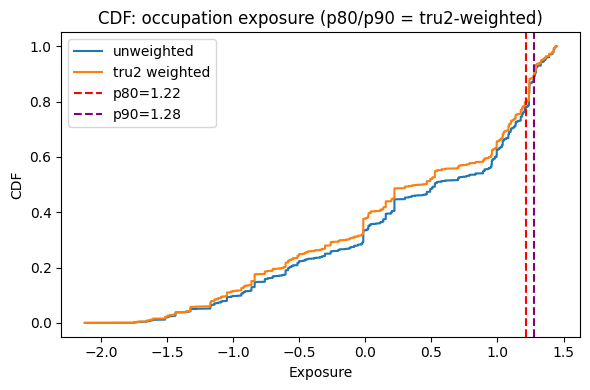

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_cdf_occ.png


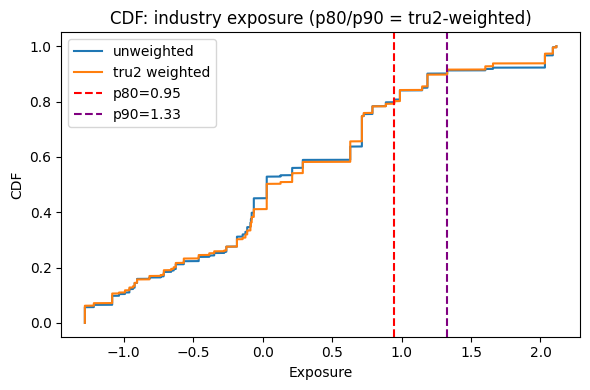

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_cdf_ind.png


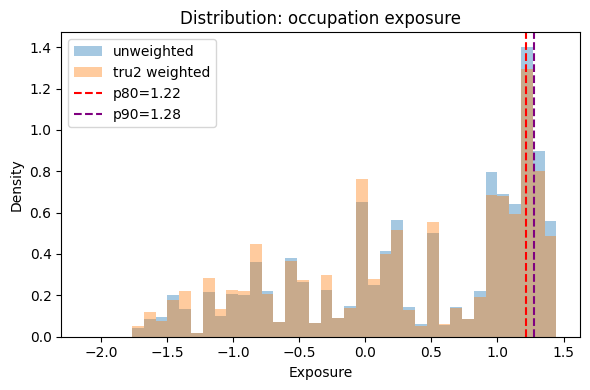

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_pdf_occ.png


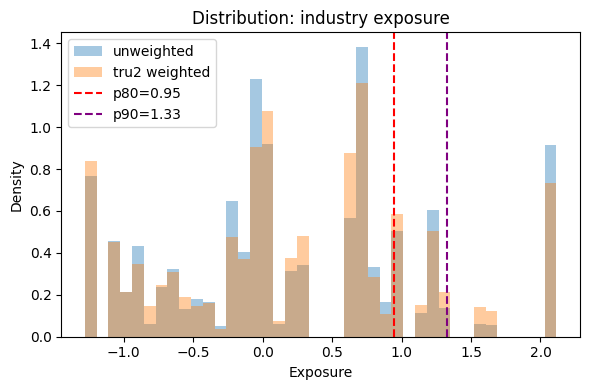

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_pdf_ind.png


In [361]:
def plot_cdf(series, weights=None, label="weighted", ax=None):
    s = series.dropna().to_numpy()
    if weights is None:
        w = np.ones_like(s)
    else:
        w = weights.loc[series.dropna().index].to_numpy()
    order = np.argsort(s)
    s_sorted = s[order]
    w_sorted = w[order]
    cum = np.cumsum(w_sorted)
    cum = cum / cum[-1]
    ax.plot(s_sorted, cum, label=label)

# Occupation CDF
fig, ax = plt.subplots(figsize=(6,4))
plot_cdf(_df[occ_exp_col], None, label="unweighted", ax=ax)
plot_cdf(_df[occ_exp_col], _df["srvy_wght_tru2"], label="tru2 weighted", ax=ax)
ax.axvline(occ_p80, color='red', linestyle='--', label=f'p80={occ_p80:.2f}')
ax.axvline(occ_p90, color='purple', linestyle='--', label=f'p90={occ_p90:.2f}')
ax.set_title("CDF: occupation exposure (p80/p90 = tru2‑weighted)")
ax.set_xlabel("Exposure")
ax.set_ylabel("CDF")
ax.legend()
plt.tight_layout()
fig_path = OUT_VIS / "fig_cdf_occ.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# Industry CDF
fig, ax = plt.subplots(figsize=(6,4))
plot_cdf(_df[ind_exp_col], None, label="unweighted", ax=ax)
plot_cdf(_df[ind_exp_col], _df["srvy_wght_tru2"], label="tru2 weighted", ax=ax)
ax.axvline(ind_p80, color='red', linestyle='--', label=f'p80={ind_p80:.2f}')
ax.axvline(ind_p90, color='purple', linestyle='--', label=f'p90={ind_p90:.2f}')
ax.set_title("CDF: industry exposure (p80/p90 = tru2‑weighted)")
ax.set_xlabel("Exposure")
ax.set_ylabel("CDF")
ax.legend()
plt.tight_layout()
fig_path = OUT_VIS / "fig_cdf_ind.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)


# Occupation distribution (non-cumulative)
fig, ax = plt.subplots(figsize=(6,4))
occ_s = _df[occ_exp_col].dropna()
occ_w = _df.loc[occ_s.index, "srvy_wght_tru2"]
bins = 40
ax.hist(occ_s, bins=bins, density=True, alpha=0.4, label="unweighted")
ax.hist(occ_s, bins=bins, density=True, weights=occ_w, alpha=0.4, label="tru2 weighted")
ax.axvline(occ_p80, color='red', linestyle='--', label=f'p80={occ_p80:.2f}')
ax.axvline(occ_p90, color='purple', linestyle='--', label=f'p90={occ_p90:.2f}')
ax.set_title("Distribution: occupation exposure")
ax.set_xlabel("Exposure")
ax.set_ylabel("Density")
ax.legend()
plt.tight_layout()
fig_path = OUT_VIS / "fig_pdf_occ.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# Industry distribution (non-cumulative)
fig, ax = plt.subplots(figsize=(6,4))
ind_s = _df[ind_exp_col].dropna()
ind_w = _df.loc[ind_s.index, "srvy_wght_tru2"]
ax.hist(ind_s, bins=bins, density=True, alpha=0.4, label="unweighted")
ax.hist(ind_s, bins=bins, density=True, weights=ind_w, alpha=0.4, label="tru2 weighted")
ax.axvline(ind_p80, color='red', linestyle='--', label=f'p80={ind_p80:.2f}')
ax.axvline(ind_p90, color='purple', linestyle='--', label=f'p90={ind_p90:.2f}')
ax.set_title("Distribution: industry exposure")
ax.set_xlabel("Exposure")
ax.set_ylabel("Density")
ax.legend()
plt.tight_layout()
fig_path = OUT_VIS / "fig_pdf_ind.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)


## 4) Concentration: Top‑X curve + summary

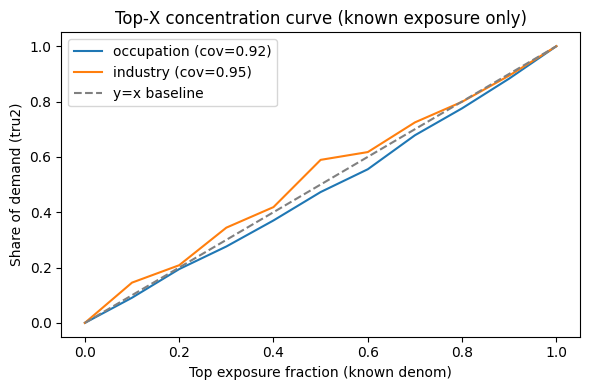

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_topx_known_denom.png


top_fraction  occ_share  ind_share
0            0.0   0.000000   0.000000
1            0.1   0.090915   0.145514
2            0.2   0.194322   0.208364
3            0.3   0.276060   0.344134
4            0.4   0.370185   0.418411
5            0.5   0.472856   0.589156
6            0.6   0.555198   0.617293
7            0.7   0.678099   0.724606
8            0.8   0.775447   0.799009
9            0.9   0.883051   0.893890
10           1.0   1.000000   1.000000

In [362]:
def demand_share_at_threshold(col, thresh, weight_col):
    mask = _df[col].notna()
    denom = _df.loc[mask, weight_col].sum()
    if denom == 0:
        return np.nan
    return _df.loc[mask & (_df[col] >= thresh), weight_col].sum() / denom

rows = []
for col, label, p80, p90 in [
    (occ_exp_col, "occupation", occ_p80, occ_p90),
    (ind_exp_col, "industry", ind_p80, ind_p90),
]:
    p10 = weighted_quantile(_df[col], _df["srvy_wght_tru2"], 0.10)
    p50 = weighted_quantile(_df[col], _df["srvy_wght_tru2"], 0.50)
    row = {"measure": label}
    row["p80"] = p80
    row["p90"] = p90
    row["p10"] = p10
    row["p50"] = p50
    row["coverage_tru2"] = _df.loc[_df[col].notna(), "srvy_wght_tru2"].sum() / _df["srvy_wght_tru2"].sum()
    # tru2 (known-denom)
    row["share_top10_tru2"] = demand_share_at_threshold(col, p90, "srvy_wght_tru2")
    row["share_top20_tru2"] = demand_share_at_threshold(col, p80, "srvy_wght_tru2")
    row["share_top50_tru2"] = demand_share_at_threshold(col, p50, "srvy_wght_tru2")
    row["share_bottom10_tru2"] = _df.loc[_df[col].notna() & (_df[col] <= p10), "srvy_wght_tru2"].sum() / _df.loc[_df[col].notna(), "srvy_wght_tru2"].sum()
    # tru1 check (known-denom)
    row["share_top10_tru1"] = demand_share_at_threshold(col, p90, "srvy_wght_tru1")
    row["share_top20_tru1"] = demand_share_at_threshold(col, p80, "srvy_wght_tru1")
    row["share_top50_tru1"] = demand_share_at_threshold(col, p50, "srvy_wght_tru1")
    row["share_bottom10_tru1"] = _df.loc[_df[col].notna() & (_df[col] <= p10), "srvy_wght_tru1"].sum() / _df.loc[_df[col].notna(), "srvy_wght_tru1"].sum()
    rows.append(row)

concentration_tbl = pd.DataFrame(rows)
concentration_tbl.to_csv(OUT_TABLES / "table_concentration_summary.csv", index=False)
concentration_tbl

# Known-denom Top-X curve
occ_nonmiss = _df[_df[occ_exp_col].notna()].copy()
ind_nonmiss = _df[_df[ind_exp_col].notna()].copy()
occ_total = occ_nonmiss['srvy_wght_tru2'].sum()
ind_total = ind_nonmiss['srvy_wght_tru2'].sum()
xs = np.linspace(0, 1, 11)

def topx_share_nonmiss(sub_df, col, frac):
    if frac <= 0:
        return 0.0
    s = pd.to_numeric(sub_df[col], errors='coerce').to_numpy(dtype=float)
    w = sub_df['srvy_wght_tru2'].to_numpy(dtype=float)
    valid = ~np.isnan(s)
    s = s[valid]
    w = w[valid]
    if len(s) == 0:
        return np.nan
    cutoff = np.nanquantile(s, 1 - frac)
    mask = s >= cutoff
    return w[mask].sum() / w.sum()

rows = []
for x in xs:
    rows.append({
        'top_fraction': x,
        'occ_share': topx_share_nonmiss(occ_nonmiss, occ_exp_col, x),
        'ind_share': topx_share_nonmiss(ind_nonmiss, ind_exp_col, x),
    })
conc_curve = pd.DataFrame(rows)

cov_occ = occ_total / _df['srvy_wght_tru2'].sum()
cov_ind = ind_total / _df['srvy_wght_tru2'].sum()

plt.figure(figsize=(6,4))
plt.plot(conc_curve['top_fraction'], conc_curve['occ_share'], label=f'occupation (cov={cov_occ:.2f})')
plt.plot(conc_curve['top_fraction'], conc_curve['ind_share'], label=f'industry (cov={cov_ind:.2f})')
plt.plot(conc_curve['top_fraction'], conc_curve['top_fraction'], linestyle='--', color='gray', label='y=x baseline')
plt.xlabel('Top exposure fraction (known denom)')
plt.ylabel('Share of demand (tru2)')
plt.title('Top‑X concentration curve (known exposure only)')
plt.legend()
plt.tight_layout()
fig_path = OUT_VIS / "fig_topx_known_denom.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)
conc_curve


## 5) Impact zones — Occupations (ISCO 1, 2, and 4‑digit)


Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/table_occ1_full.csv


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/1361584668.py:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  occ1_metrics["mean_occ_exp_tru2"] = occ1_group.apply(lambda g: wmean(g, occ_exp_col)).values


occ1_code                                         occ1_label  \
1         1                                           Managers   
4         4                           Clerical support workers   
2         2                                      Professionals   
3         3            Technicians and associate professionals   
5         5                          Service and sales workers   
8         8        Plant and machine operators, and assemblers   
7         7                   Craft and related trades workers   
6         6  Skilled agricultural, forestry and fishery wor...   
9         9                             Elementary occupations   
0         0                           Armed forces occupations   

   demand_total_tru2  postings_total_tru1  n_ads  mean_occ_exp_tru2  
1         91537.2124           90578.3302   4097           1.027624  
4        176291.7494          162884.8689   7209           0.992728  
2        488186.3847          466144.2435  18531           0.974903  
3        325930.3789          310510.4393  12114           0.446034  
5         229944.986          200616.1767   7409          -0.334277  
8         50935.7891           44847.0071   1791          -0.774513  
7         227704.493          202966.9574   6963          -1.005614  
6          9622.3608            8791.2909    363          -1.101813  
9         36799.1455            28909.682   1250          -1.374436  
0          1194.3476            1037.7297     67                NaN

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/table_occ2_full.csv


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/1361584668.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  occ2_metrics["mean_occ_exp_tru2"] = occ2_group.apply(lambda g: wmean(g, occ_exp_col)).values


occ2_code                                         occ2_label  \
12        24          Business and administration professionals   
5         12             Administrative and commercial managers   
22        41                        General and keyboard clerks   
14        26           Legal, social and cultural professionals   
13        25  Information and communications technology prof...   
18        33  Business and administration associate professi...   
9         21              Science and engineering professionals   
4         11  Chief executives, senior officials and legisla...   
24        43            Numerical and material recording clerks   
25        44                     Other clerical support workers   
11        23                             Teaching professionals   
6         13       Production and specialised services managers   
23        42                           Customer services clerks   
20        35         Information and communications technicians   
19        34  Legal, social, cultural and related associate ...   
10        22                               Health professionals   
7         14    Hospitality, retail and other services managers   
16        31    Science and engineering associate professionals   
28        52                                      Sales workers   
17        32                     Health associate professionals   
30        54                        Protective services workers   
29        53                              Personal care workers   
36        73                    Handicraft and printing workers   
42        83                 Drivers and mobile plant operators   
38        75  Food processing, woodworking, garment and othe...   
37        74           Electrical and electronic trades workers   
27        51                           Personal service workers   
41        82                                         Assemblers   
40        81             Stationary plant and machine operators   
32        62  Market-oriented skilled forestry, fishery and ...   
48        96        Refuse workers and other elementary workers   
35        72        Metal, machinery and related trades workers   
31        61       Market-oriented skilled agricultural workers   
34        71  Building and related trades workers (excluding...   
46        93  Labourers in mining, construction, manufacturi...   
44        91                               Cleaners and helpers   
45        92       Agricultural, forestry and fishery labourers   
47        94                        Food preparation assistants   
0         00                                            Unknown   
1         01                 Commissioned armed forces officers   
2         03              Armed forces occupations, other ranks   
3         10               Unknown sub-major (major group only)   
8         20               Unknown sub-major (major group only)   
15        30               Unknown sub-major (major group only)   
21        40               Unknown sub-major (major group only)   
26        50               Unknown sub-major (major group only)   
33        70               Unknown sub-major (major group only)   
39        80               Unknown sub-major (major group only)   
43        90               Unknown sub-major (major group only)   

    demand_total_tru2  postings_total_tru1  n_ads  mean_occ_exp_tru2  
12         94457.2123           90997.9087   3911           1.293706  
5          46026.6106           46044.4836   1830           1.253743  
22         64141.7672           57852.5017   2535           1.221306  
14         34916.8839           30927.6603   1409           1.207995  
13         114012.381          112983.8243   4066           1.194364  
18          98144.907            93285.477   4270           1.047808  
9          96075.5559           94896.6775   3141           1.045777  
4          11207.6684           11158.4538    661           0.961023  
24         45

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/table_occ4_top25_exposure.csv
Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/table_occ4_bottom25_exposure.csv


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/1361584668.py:98: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  occ4_metrics["mean_occ_exp_tru2"] = occ4_group.apply(lambda g: wmean(g, occ_exp_col)).values


occ4_code occ4_label  demand_total_tru2  postings_total_tru1  n_ads  \
9        1211       1211          3495.6574            3495.6574    140   
43       2120       2120          3302.2187            3202.8701    146   
116      2612       2612          1402.1959            1091.4363     26   
117      2619       2619          4634.5033             4554.424    226   
92       2411       2411         16992.3107            16307.398    627   
94       2413       2413          6043.9557            6010.6425    262   
124      2634       2634          4111.5871            3462.8513    158   
121      2631       2631          1587.9024            1319.5679     79   
93       2412       2412         12219.8399           10885.9884    498   
181      3312       3312          1261.5201            1261.5201     66   
40       2112       2112             34.487               34.487      2   
200      3352       3352           799.6098             784.9397     57   
95       2421       2421          8053.7932            7952.7909    351   
39       2111       2111          1420.6198            1391.4198     85   
250      4416       4416           5743.675            5727.0083    293   
50       2143       2143           536.0654             536.0654     31   
74       2265       2265          1480.3232             916.2933     41   
52       2145       2145           3983.151            4079.5496     93   
115      2611       2611          5616.5275            5033.8178    128   
185      3321       3321         10101.8257            8815.4218    498   
188      3324       3324          1338.1319            1303.6319     63   
84       2351       2351          2002.5896            2040.3219    113   
10       1212       1212          4248.5398             4279.027    199   
235      4227       4227            38.0295              24.8979      4   
14       1222       1222          3076.3263            3217.4391    116   

     mean_occ_exp_tru2  
9             1.446232  
43            1.439613  
116           1.435604  
117           1.431593  
92            1.426218  
94            1.417316  
124           1.416230  
121           1.403764  
93            1.390682  
181           1.385560  
40            1.373917  
200           1.366820  
95            1.364860  
39            1.359736  
250           1.353098  
50            1.343561  
74            1.342809  
52            1.341336  
115           1.328783  
185           1.328035  
188           1.325969  
84            1.301855  
10            1.301025  
235           1.297031  
14            1.294038

occ4_code occ4_label  demand_total_tru2  postings_total_tru1  n_ads  \
132      2653       2653            10.6667               5.3333      1   
410      9121       9121            70.6236              70.6236      5   
307      7121       7121           3643.987            3075.8136     71   
421      9313       9313          2234.8459            1824.2314     79   
417      9214       9214           1231.138              988.604     46   
314      7131       7131          3779.6266            3049.0429     92   
309      7123       7123          2286.9339            1798.4729     44   
429      9412       9412          3177.6866            2612.3874    130   
411      9122       9122            41.3889              41.3889      3   
322      7214       7214          6395.2852            6647.1668    139   
414      9211       9211            505.617             511.9782      5   
419      9311       9311             10.475               10.475      2   
409      9112       9112          7869.7783            6441.1297    399   
422      9321       9321           652.5656               476.93     23   
303      7114       7114          1801.9243            1648.9957     47   
301      7112       7112          5707.8088            3802.4102    158   
408      9111       9111          2545.4675            2578.8933     75   
308      7122       7122          2379.1509            2134.1037     51   
310      7124       7124          2465.0582            2062.5279     67   
319      7211       7211           245.7843             245.7843     10   
412      9123       9123                7.2                  3.6      1   
263      5153       5153          10197.876            8534.6498    626   
380      8151       8151            12.8829              12.8829      1   
311      7125       7125           787.4839             787.4839     13   
363      7535       7535            90.3277              90.3277      2   

     mean_occ_exp_tru2  
132          -2.122764  
410          -1.950063  
307          -1.752941  
421          -1.731342  
417          -1.712821  
314          -1.657760  
309          -1.648111  
429          -1.630702  
411          -1.629897  
322          -1.609123  
414          -1.601349  
419          -1.543154  
409          -1.515585  
422          -1.513620  
303          -1.512067  
301          -1.495901  
408          -1.480657  
308          -1.459938  
310          -1.443694  
319          -1.443244  
412          -1.436201  
263          -1.436201  
380          -1.392929  
311          -1.388901  
363          -1.370968

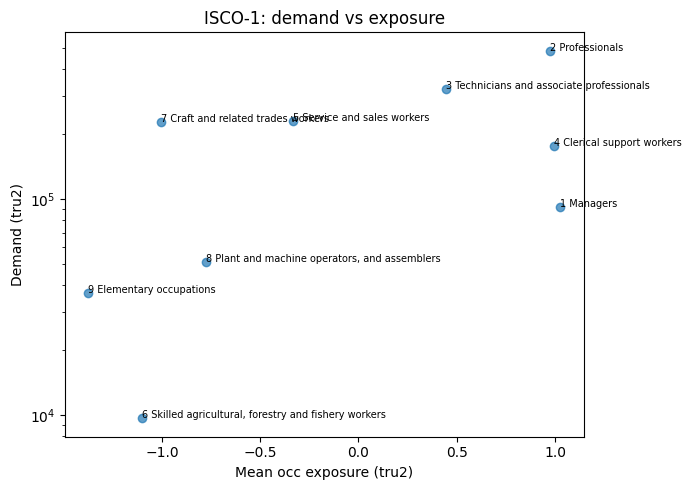

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_occ1_scatter.png
ISCO-4 Pearson: 0.12465482023319906
ISCO-4 Spearman: 0.26434821041554063
ISCO-4 Weighted Pearson: 0.058428984872153686
ISCO-2 Pearson: 0.43345623499297714
ISCO-2 Spearman: 0.5410876463508042
ISCO-2 Weighted Pearson: 0.22417575065587225
ISCO-1 Pearson: 0.5593074726592052
ISCO-1 Spearman: 0.5166666666666667
ISCO-1 Weighted Pearson: 0.5423773569109778


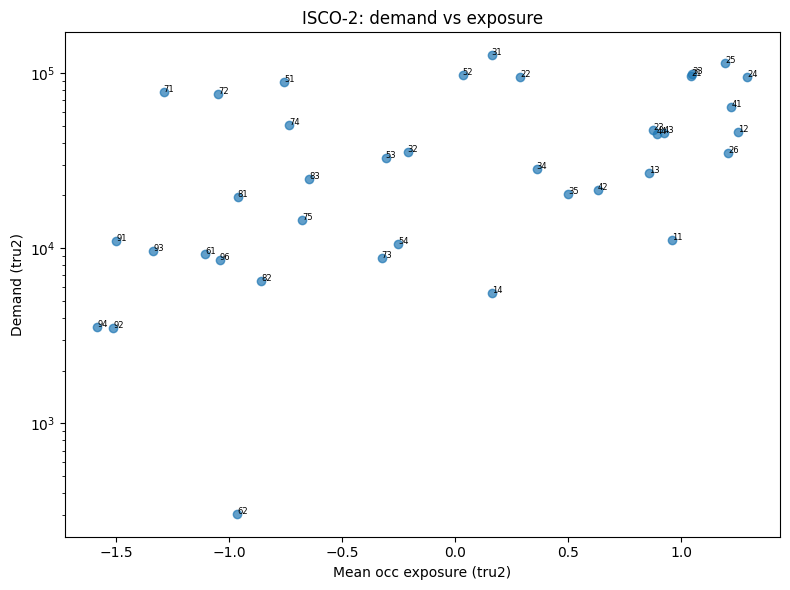

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_occ2_scatter_full.png


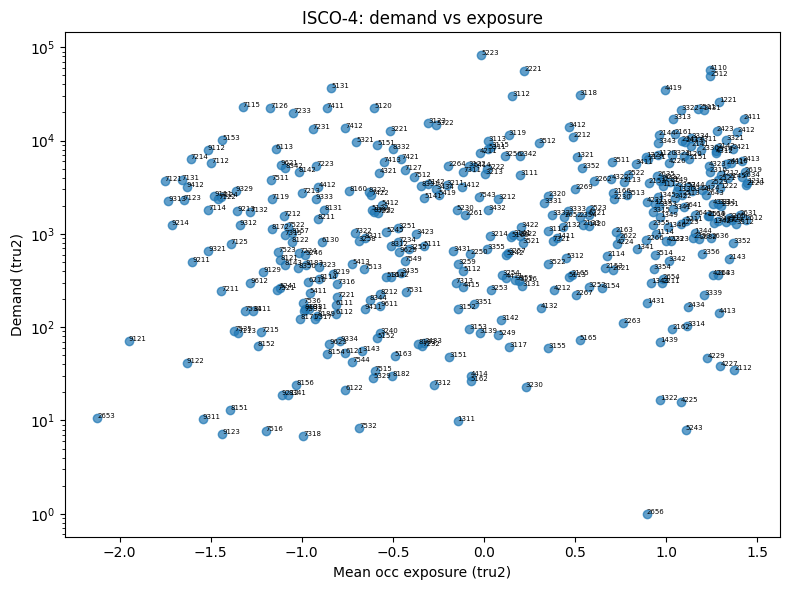

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_occ4_scatter_full.png


In [365]:
# Occupation impact lists (ISCO 1, 2, 4)

# Build codes/labels (in-memory)
_df["occ1_code"] = isco_raw_str.str[:1]
_df["occ1_label"] = _df["occu_isco1_label"].fillna("Unknown")
_df["occ2_code"] = isco_raw_str.str[:2]
_df["occ2_label"] = _df["occu_isco2_label"].fillna("Unknown")
_df["occ4_code"] = isco_raw_str
if "occu_isco4_label" in _df.columns:
    _df["occ4_label"] = _df["occu_isco4_label"].fillna(_df["occ4_code"])
else:
    _df["occ4_label"] = _df["occ4_code"]

# Weighted mean helper

def wmean(group, col):
    x = group[col]
    w = group["srvy_wght_tru2"]
    mask = x.notna()
    if mask.sum() == 0:
        return np.nan
    return np.average(x[mask], weights=w[mask])


# Correlation helper for scatter plots

def _to_1d(arr):
    if isinstance(arr, pd.DataFrame):
        arr = arr.iloc[:, 0]
    return pd.to_numeric(pd.Series(arr), errors="coerce").to_numpy()


def print_corr_metrics(label, df, x_col, y_col, w_col="demand_total_tru2"):
    # handle duplicate columns by picking first occurrence
    if isinstance(df, pd.DataFrame):
        df = df.loc[:, ~df.columns.duplicated()]
    use_cols = [x_col, y_col]
    if w_col in df.columns:
        use_cols.append(w_col)
    valid = df[use_cols].dropna()
    if valid.empty:
        print(f"{label}: no valid rows for correlation")
        return
    x = _to_1d(valid[x_col])
    y = _to_1d(valid[y_col])
    pearson = pd.Series(x).corr(pd.Series(y))
    spearman = pd.Series(x).corr(pd.Series(y), method="spearman")
    print(f"{label} Pearson:", pearson)
    print(f"{label} Spearman:", spearman)
    if w_col in valid.columns:
        w = _to_1d(valid[w_col])
        if w.sum() > 0:
            wmx = (x * w).sum() / w.sum()
            wmy = (y * w).sum() / w.sum()
            wcov = (w * (x - wmx) * (y - wmy)).sum() / w.sum()
            wsx = ((w * (x - wmx) ** 2).sum() / w.sum()) ** 0.5
            wsy = ((w * (y - wmy) ** 2).sum() / w.sum()) ** 0.5
            weighted = wcov / (wsx * wsy) if wsx > 0 and wsy > 0 else float('nan')
        else:
            weighted = float('nan')
        print(f"{label} Weighted Pearson:", weighted)

# ISCO-1 full list
occ1_group = _df.groupby(["occ1_code", "occ1_label"])
occ1_metrics = occ1_group.agg(
    demand_total_tru2=("srvy_wght_tru2", "sum"),
    postings_total_tru1=("srvy_wght_tru1", "sum"),
    n_ads=("srvy_wght_tru2", "size")
).reset_index()
occ1_metrics["mean_occ_exp_tru2"] = occ1_group.apply(lambda g: wmean(g, occ_exp_col)).values
occ1_metrics = occ1_metrics.sort_values("mean_occ_exp_tru2", ascending=False)
occ1_metrics.to_csv(OUT_TABLES / "table_occ1_full.csv", index=False)
print("Saved", OUT_TABLES / "table_occ1_full.csv")

display(occ1_metrics)

# ISCO-2 full list
occ2_group = _df.groupby(["occ2_code", "occ2_label"])
occ2_metrics = occ2_group.agg(
    demand_total_tru2=("srvy_wght_tru2", "sum"),
    postings_total_tru1=("srvy_wght_tru1", "sum"),
    n_ads=("srvy_wght_tru2", "size")
).reset_index()
occ2_metrics["mean_occ_exp_tru2"] = occ2_group.apply(lambda g: wmean(g, occ_exp_col)).values
occ2_metrics = occ2_metrics.sort_values("mean_occ_exp_tru2", ascending=False)
occ2_metrics.to_csv(OUT_TABLES / "table_occ2_full.csv", index=False)
print("Saved", OUT_TABLES / "table_occ2_full.csv")

display(occ2_metrics)

# ISCO-4 top/bottom 25 by exposure (with labels)
occ4_group = _df.groupby(["occ4_code", "occ4_label"])
occ4_metrics = occ4_group.agg(
    demand_total_tru2=("srvy_wght_tru2", "sum"),
    postings_total_tru1=("srvy_wght_tru1", "sum"),
    n_ads=("srvy_wght_tru2", "size")
).reset_index()
occ4_metrics["mean_occ_exp_tru2"] = occ4_group.apply(lambda g: wmean(g, occ_exp_col)).values

occ4_top25 = occ4_metrics.nlargest(25, "mean_occ_exp_tru2")
occ4_bottom25 = occ4_metrics.nsmallest(25, "mean_occ_exp_tru2")

occ4_top25.to_csv(OUT_TABLES / "table_occ4_top25_exposure.csv", index=False)
occ4_bottom25.to_csv(OUT_TABLES / "table_occ4_bottom25_exposure.csv", index=False)
print("Saved", OUT_TABLES / "table_occ4_top25_exposure.csv")
print("Saved", OUT_TABLES / "table_occ4_bottom25_exposure.csv")

display(occ4_top25)
display(occ4_bottom25)

# Scatter: ISCO-1 demand vs exposure
occ1_plot = _finite_for_plot(occ1_metrics, "mean_occ_exp_tru2", "demand_total_tru2", y_positive=True)
plt.figure(figsize=(7,5))
plt.scatter(occ1_plot["mean_occ_exp_tru2"], occ1_plot["demand_total_tru2"], alpha=0.7)
for _, row in occ1_plot.iterrows():
    label = f"{row['occ1_code']} {row['occ1_label']}"
    plt.text(row["mean_occ_exp_tru2"], row["demand_total_tru2"], label, fontsize=7)
plt.xlabel("Mean occ exposure (tru2)")
plt.ylabel("Demand (tru2)")
plt.yscale("log")
plt.title("ISCO‑1: demand vs exposure")
plt.tight_layout()
fig_path = OUT_VIS / "fig_occ1_scatter.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)
print_corr_metrics("ISCO-4", occ4_plot, "mean_occ_exp_tru2", "demand_total_tru2")
print_corr_metrics("ISCO-2", occ2_plot, "mean_occ_exp_tru2", "demand_total_tru2")
print_corr_metrics("ISCO-1", occ1_plot, "mean_occ_exp_tru2", "demand_total_tru2")

# Scatter: ISCO-2 demand vs exposure (IDs only)
occ2_plot = _finite_for_plot(occ2_metrics, "mean_occ_exp_tru2", "demand_total_tru2", y_positive=True)
plt.figure(figsize=(8,6))
plt.scatter(occ2_plot["mean_occ_exp_tru2"], occ2_plot["demand_total_tru2"], alpha=0.7)
for _, row in occ2_plot.iterrows():
    label = str(row["occ2_code"])
    plt.text(row["mean_occ_exp_tru2"], row["demand_total_tru2"], label, fontsize=6)
plt.xlabel("Mean occ exposure (tru2)")
plt.ylabel("Demand (tru2)")
plt.yscale("log")
plt.title("ISCO‑2: demand vs exposure")
plt.tight_layout()
fig_path = OUT_VIS / "fig_occ2_scatter_full.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)


# Scatter: ISCO-4 demand vs exposure (IDs only)
occ4_plot = _finite_for_plot(occ4_metrics, "mean_occ_exp_tru2", "demand_total_tru2", y_positive=True)
plt.figure(figsize=(8,6))
plt.scatter(occ4_plot["mean_occ_exp_tru2"], occ4_plot["demand_total_tru2"], alpha=0.7)
for _, row in occ4_plot.iterrows():
    label = str(row["occ4_code"])
    plt.text(row["mean_occ_exp_tru2"], row["demand_total_tru2"], label, fontsize=5)
plt.xlabel("Mean occ exposure (tru2)")
plt.ylabel("Demand (tru2)")
plt.yscale("log")
plt.title("ISCO‑4: demand vs exposure")
plt.tight_layout()
fig_path = OUT_VIS / "fig_occ4_scatter_full.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)



## 5.2) Impact zones — Industries (comp_indu_noga + NOGA section)


Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/table_ind_full_comp_noga.csv


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/1997205572.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ind_metrics["mean_ind_exp_tru2"] = ind_group.apply(lambda g: wmean(g, ind_exp_col)).values


noga_code                                         noga_label  \
28        35  Activities auxiliary to financial and insuranc...   
27        34  Insurance, reinsurance and pension funding (ex...   
26        33                       Financial service activities   
30        37  Legal and accounting activities; auditing; tax...   
31        38  Activities of head offices; management consult...   
24        31  Publishing; audiovisual and broadcasting activ...   
37        43                                          Education   
42        48  Membership organisations; religious and other ...   
25        32  Telecommunications; IT services; information s...   
29        36                             Real estate activities   
34        40  Scientific research and development; other pro...   
4         13  Manufacture of computer, electronic and optica...   
40        46       Social work activities without accommodation   
38        44                            Human health activities   
32        39  Architectural and engineering activities; tech...   
15        23  Wholesale trade (excluding motor vehicles and ...   
39        45  Residential care activities (excluding holiday...   
49         8  Manufacture of basic pharmaceutical products a...   
16        24  Retail trade (excluding motor vehicles and mot...   
36        42  Public administration and defence; compulsory ...   
35        41  Administrative and other business support serv...   
47         6        Printing and reproduction of recorded media   
14        22  Wholesale and retail trade and repair of motor...   
17        25         Land transport and transport via pipelines   
5         14                Manufacture of electrical equipment   
41        47                 Arts, entertainment and recreation   
6         15             Manufacture of machinery and equipment   
48         7  Manufacture of chemicals; coke and refined pet...   
7         16  Manufacture of motor vehicles, trailers and ot...   
43        49  Repair of computers and personal/household goo...   
18        26                  Water transport and air transport   
8         17  Other manufacturing; repair and installation o...   
3         12           Manufacture of fabricated metal products   
9         18  Electricity, gas, water supply; sewerage, wast...   
44         5            Manufacture of paper and paper products   
22         3        Manufacture of textiles and wearing apparel   
10        19                          Construction of buildings   
50         9         Manufacture of rubber and plastic products   
1         10  Manufacture of glass and glass products; ceram...   
21        29                                      Accommodation   
2         11         Manufacture and processing of basic metals   
11         2  Manufacture of food products and tobacco products   
12        20                                  Civil engineering   
19        27  Warehousing and support activities for transpo...   
33         4  Manufacture of wood and of products of wood, s...   
0          1                  Agriculture, forestry and fishing   
23        30               Food and beverage service activities   
20        28                      Postal and courier activities   
13        21                Specialised construction activities   
45        50  Activities of households as employers; undiffe...   
46        51  Not stated; activities of extraterritorial org...   

    demand_total_tru2  postings_total_tru1  n_ads  mean_ind_exp_tru2  
28           7319.281            7262.4957    231           2.114970  
27         34800.1121           32067.0302   1680           2.089173  
26         54843.9067           53028.7561   2527           2.032305  
30         16349.1446            14666.688    275           1.658205  
31         18428.0581           18123.4947    296           1.603006  
24         28163.8821           29027.8664    660           1.328372  
37         66308.8791

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/table_ind_full_section.csv


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/1997205572.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sec_metrics["mean_sec_exp_tru2"] = sec_group.apply(lambda g: wmean(g, "industry_section_exposure_weighted")).values


section_code                                      section_label  \
8             K                 Financial and insurance activities   
13            P                                          Education   
7             J                      Information and communication   
10            M  Professional, scientific and technical activities   
9             L                             Real estate activities   
14            Q            Human health and social work activities   
4             G  Wholesale and retail trade; repair of motor ve...   
16            S                           Other service activities   
12            O  Public administration and defence; compulsory ...   
11            N      Administrative and support service activities   
15            R                 Arts, entertainment and recreation   
1             C                                      Manufacturing   
5             H                         Transportation and storage   
2            DE  Electricity, gas, water supply; sewerage, wast...   
6             I          Accommodation and food service activities   
0            AB          Agriculture, forestry, fishing and mining   
3             F                                       Construction   
17            T              Activities of households as employers   
18            U       Activities of extraterritorial organisations   

    demand_total_tru2  postings_total_tru1  n_ads  mean_sec_exp_tru2  
8          96963.2998            92358.282   4438           2.072848  
13         66308.8791           62208.8672   2925           1.186285  
7           90902.341           88618.7283   2553           1.177146  
10        164425.5273          158335.8369   4131           1.047356  
9          14723.8277           14469.7835    561           0.947543  
14        209411.7959          184823.8547   8222           0.627138  
4         231164.6441          216622.6414   7005           0.120153  
16         31268.5622             28422.65   1058           0.099941  
12         43741.5326           39917.2254   2983          -0.063951  
11         31162.4703           27547.8435   1312          -0.079286  
15          8916.6844            7491.1904    468          -0.144358  
1         276762.2627          261290.6626  11496          -0.450426  
5          62305.0081           57961.7257   2438          -0.525983  
2          24200.1723           23039.6806    982          -0.625946  
6          73621.2419           68061.0685   2152          -0.986206  
0           5606.3021            4378.4785    359          -1.034561  
3         123097.7805          108705.1626   4047          -1.128442  
17         21911.0106           19245.5574    927                NaN  
18         61653.5048           53787.4865   1737                NaN

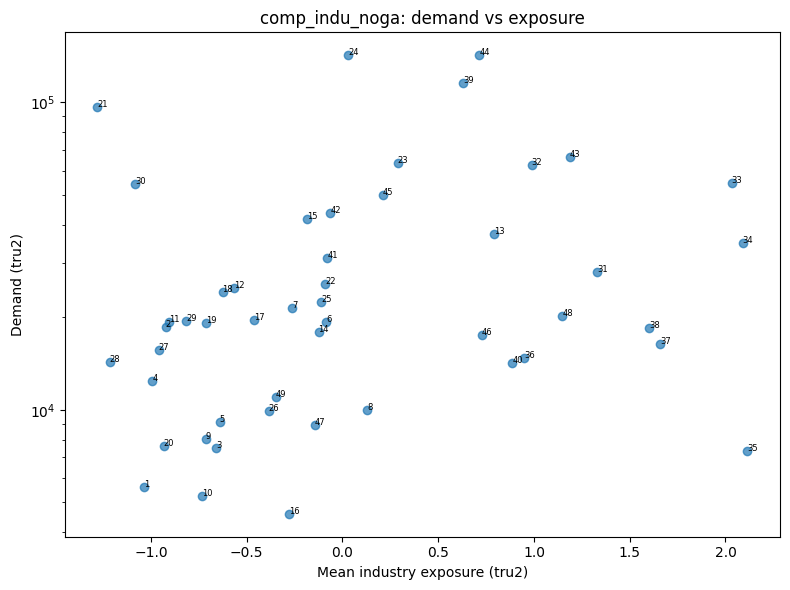

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_ind_scatter_full.png
NOGA section Pearson: 0.11009627077258945
NOGA section Spearman: 0.2622549019607843
NOGA section Weighted Pearson: -0.1562985644951362
comp_indu_noga Pearson: 0.183746278606095
comp_indu_noga Spearman: 0.32357142857142857
comp_indu_noga Weighted Pearson: 0.10154224398132873


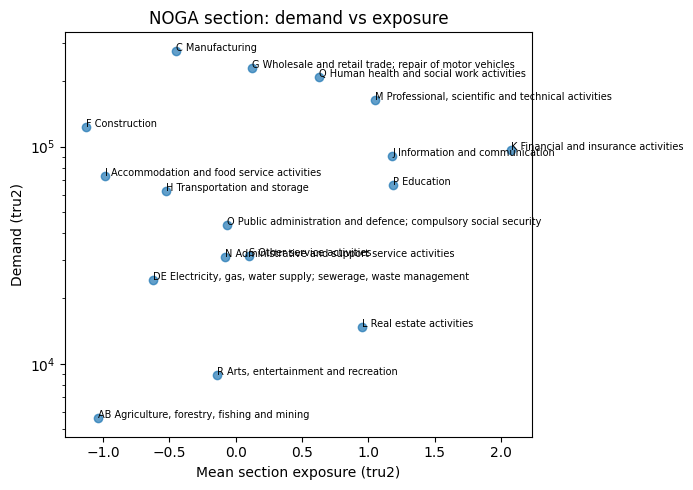

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_section_scatter_full.png


In [366]:
# Industry impact lists (comp_indu_noga + NOGA section)

# comp_indu_noga full list
_df["noga_code"] = _df["comp_indu_noga"].astype("string")
_df["noga_label"] = _df["comp_indu_noga_label"].fillna("Unknown")

ind_group = _df.groupby(["noga_code", "noga_label"])
ind_metrics = ind_group.agg(
    demand_total_tru2=("srvy_wght_tru2","sum"),
    postings_total_tru1=("srvy_wght_tru1","sum"),
    n_ads=("srvy_wght_tru2","size")
).reset_index()
ind_metrics["mean_ind_exp_tru2"] = ind_group.apply(lambda g: wmean(g, ind_exp_col)).values
ind_metrics = ind_metrics.sort_values("mean_ind_exp_tru2", ascending=False)
ind_metrics.to_csv(OUT_TABLES / "table_ind_full_comp_noga.csv", index=False)
print("Saved", OUT_TABLES / "table_ind_full_comp_noga.csv")

display(ind_metrics)

# NOGA section full list
_df["section_code"] = _df["industry_section"].astype("string")
_df["section_label"] = _df["industry_section_label"].fillna(_df["industry_section"]).fillna("Unknown")

sec_group = _df.groupby(["section_code", "section_label"])
sec_metrics = sec_group.agg(
    demand_total_tru2=("srvy_wght_tru2","sum"),
    postings_total_tru1=("srvy_wght_tru1","sum"),
    n_ads=("srvy_wght_tru2","size")
).reset_index()
sec_metrics["mean_sec_exp_tru2"] = sec_group.apply(lambda g: wmean(g, "industry_section_exposure_weighted")).values
sec_metrics = sec_metrics.sort_values("mean_sec_exp_tru2", ascending=False)
sec_metrics.to_csv(OUT_TABLES / "table_ind_full_section.csv", index=False)
print("Saved", OUT_TABLES / "table_ind_full_section.csv")

display(sec_metrics)


# Scatter: comp_indu_noga demand vs exposure (IDs only)
ind_plot = _finite_for_plot(ind_metrics, "mean_ind_exp_tru2", "demand_total_tru2", y_positive=True)
plt.figure(figsize=(8,6))
plt.scatter(ind_plot["mean_ind_exp_tru2"], ind_plot["demand_total_tru2"], alpha=0.7)
for _, row in ind_plot.iterrows():
    label = str(row["noga_code"])
    plt.text(row["mean_ind_exp_tru2"], row["demand_total_tru2"], label, fontsize=6)
plt.xlabel("Mean industry exposure (tru2)")
plt.ylabel("Demand (tru2)")
plt.yscale("log")
plt.title("comp_indu_noga: demand vs exposure")
plt.tight_layout()
fig_path = OUT_VIS / "fig_ind_scatter_full.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)
print_corr_metrics("NOGA section", sec_plot, "mean_sec_exp_tru2", "demand_total_tru2")
print_corr_metrics("comp_indu_noga", ind_plot, "mean_ind_exp_tru2", "demand_total_tru2")

# Scatter: NOGA section demand vs exposure
sec_plot = _finite_for_plot(sec_metrics, "mean_sec_exp_tru2", "demand_total_tru2", y_positive=True)
plt.figure(figsize=(7,5))
plt.scatter(sec_plot["mean_sec_exp_tru2"], sec_plot["demand_total_tru2"], alpha=0.7)
for _, row in sec_plot.iterrows():
    label = f"{row['section_code']} {row['section_label']}"
    plt.text(row["mean_sec_exp_tru2"], row["demand_total_tru2"], label, fontsize=7)
plt.xlabel("Mean section exposure (tru2)")
plt.ylabel("Demand (tru2)")
plt.yscale("log")
plt.title("NOGA section: demand vs exposure")
plt.tight_layout()
fig_path = OUT_VIS / "fig_section_scatter_full.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)


## 6) Regions (Unknown kept)

In [ ]:
# Ensure color maps exist (in case cells run out of order)
# Ensure label helper functions exist even if color maps already built
if '_base_label' not in globals():
    def _base_label(label):
        s = str(label)
        if ' (exp=' in s:
            s = s.split(' (exp=')[0]
        return s
if '_normalize_other' not in globals():
    def _normalize_other(label, other_label="Other"):
        s = _base_label(label)
        if s.lower().startswith('other'):
            return other_label
        return s
if "build_color_map" not in globals():
    from matplotlib import cm
    def _base_label(label):
        s = str(label)
        # strip exposure suffix if present
        if ' (exp=' in s:
            s = s.split(' (exp=')[0]
        return s

def build_color_map(labels, other_label="Other"):
    # stable ordering as provided
    base = list(cm.get_cmap("tab20").colors) + list(cm.get_cmap("tab20b").colors) + list(cm.get_cmap("tab20c").colors)
    # mute/blend toward white
    def mute(rgb, alpha=0.7):
        r, g, b = rgb[:3]
        return (alpha*r + (1-alpha)*1.0, alpha*g + (1-alpha)*1.0, alpha*b + (1-alpha)*1.0, 1.0)
    muted = [mute(c) for c in base]

    cmap = {}
    i = 0
    for lab in labels:
        lab_norm = _normalize_other(lab, other_label=other_label)
        if lab_norm == other_label:
            continue
        if lab_norm in cmap:
            continue
        cmap[lab_norm] = muted[i % len(muted)]
        i += 1
    cmap[other_label] = (0.85, 0.85, 0.85, 1.0)
    return cmap

def color_for_label(label, cmap, other_label="Other"):
    key = _normalize_other(label, other_label=other_label)
    return cmap.get(key, (0.85,0.85,0.85,1.0))

# Build global label orders by national tru2-weighted share

# Normalize label orders (preserve importance order)
def _ordered_labels_from_series(s):
    seen = set()
    out = []
    for lab in s.index:
        lab_norm = _normalize_other(lab)
        if lab_norm in seen:
            continue
        seen.add(lab_norm)
        out.append(lab_norm)
    return out


# NOGA section
if 'noga_section_label' in _df.columns:
    _noga_label_col = 'noga_section_label'
elif 'industry_section_label' in _df.columns:
    _noga_label_col = 'industry_section_label'
else:
    _noga_label_col = None

if _noga_label_col:
    noga_section_order = (
        _df.groupby(_df[_noga_label_col].fillna('Unknown'))['srvy_wght_tru2']
           .sum().sort_values(ascending=False)
    )
else:
    noga_section_order = pd.Series([], dtype=float)
# comp_indu_noga
comp_noga_order = (
    _df.groupby(_df['comp_indu_noga_label'].fillna('Unknown'))['srvy_wght_tru2']
       .sum().sort_values(ascending=False)
)

# ISCO-1
isco1_order = (
    _df.groupby(_df['occu_isco1_label'].fillna('Unknown'))['srvy_wght_tru2']
       .sum().sort_values(ascending=False)
)

# ISCO-2
isco2_order = (
    _df.groupby(_df['occu_isco2_label'].fillna('Unknown'))['srvy_wght_tru2']
       .sum().sort_values(ascending=False)
)

# ISCO-4 (use code label in occ4_label)
if 'occ4_label' in _df.columns:
    isco4_order = (
        _df.groupby(_df['occ4_label'].fillna('Unknown'))['srvy_wght_tru2']
           .sum().sort_values(ascending=False)
    )
else:
    isco4_order = pd.Series([], dtype=float)

# Build color maps
color_map_noga_section = build_color_map(_ordered_labels_from_series(noga_section_order), other_label='Other')
color_map_comp_noga = build_color_map(_ordered_labels_from_series(comp_noga_order), other_label='Other')
color_map_isco1 = build_color_map(_ordered_labels_from_series(isco1_order), other_label='Other')
color_map_isco2 = build_color_map(_ordered_labels_from_series(isco2_order), other_label='Other')
color_map_isco4 = build_color_map(_ordered_labels_from_series(isco4_order), other_label='Other')


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/1883880778.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = list(cm.get_cmap("tab20").colors) + list(cm.get_cmap("tab20b").colors) + list(cm.get_cmap("tab20c").colors)


### 6.1) Regions — occupation exposure


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/3676461675.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reg_metrics["mean_occ_exp_tru2"] = reg_group.apply(wmean_region_occ)
/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/3676461675.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  known_denom = reg_group.apply(lambda g: g.loc[g[occ_exp_col].notna(), "srvy_wght_tr

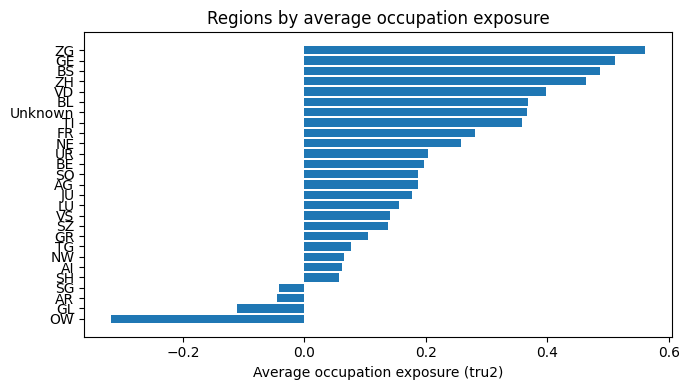

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top30_avg_exposure.png


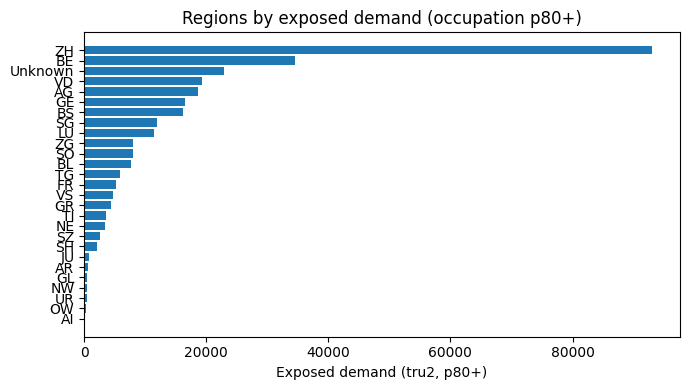

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top15_exposed_p80.png


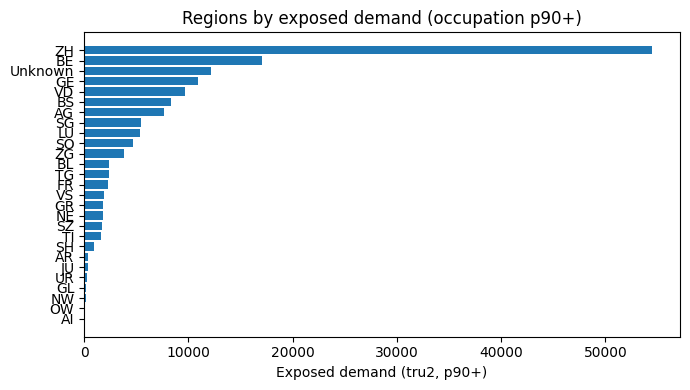

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top15_exposed_p90.png


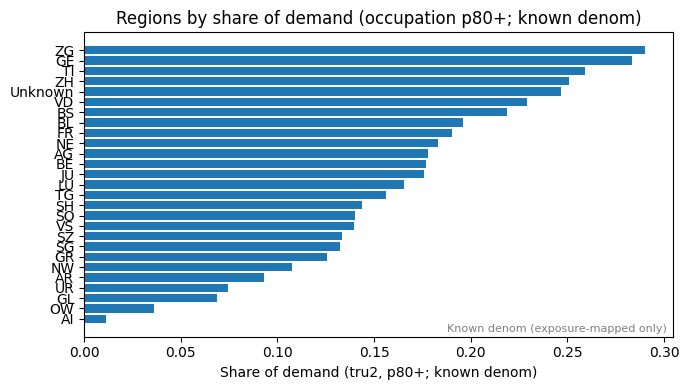

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top30_share_p80.png


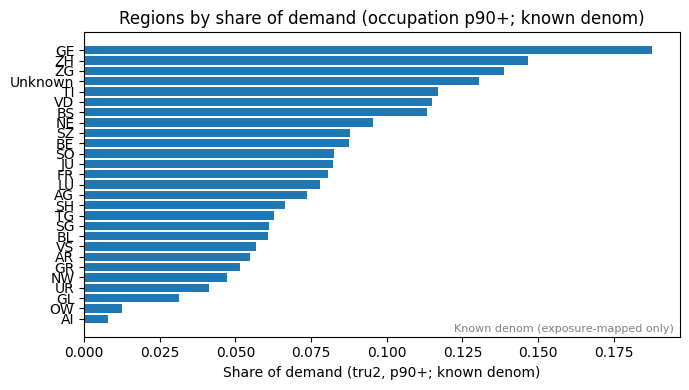

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top30_share_p90.png


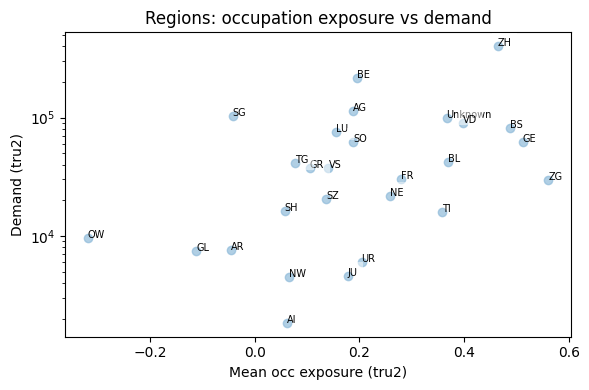

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_scatter.png


In [ ]:
# === Region analysis (occupation exposure) ===
region_col = "loca_regi_kant_label"

# Region summary (occupation exposure)
reg_group = _df.groupby(region_col)

def wmean_region_occ(g):
    x = g.loc[g[occ_exp_col].notna(), occ_exp_col]
    w = g.loc[g[occ_exp_col].notna(), "srvy_wght_tru2"]
    return np.average(x, weights=w) if len(x) else np.nan

reg_metrics = reg_group.agg(
    demand_total_tru2=("srvy_wght_tru2", "sum"),
    postings_total_tru1=("srvy_wght_tru1", "sum")
)
reg_metrics["mean_occ_exp_tru2"] = reg_group.apply(wmean_region_occ)

# exposed demand p80/p90 (occupation)
reg_metrics["exposed_demand_p80"] = _df.loc[_df[occ_exp_col] >= occ_p80].groupby(region_col)["srvy_wght_tru2"].sum()
reg_metrics["exposed_demand_p90"] = _df.loc[_df[occ_exp_col] >= occ_p90].groupby(region_col)["srvy_wght_tru2"].sum()
reg_metrics = reg_metrics.fillna(0)

# shares (known denom)
known_denom = reg_group.apply(lambda g: g.loc[g[occ_exp_col].notna(), "srvy_wght_tru2"].sum())
reg_metrics["high_share_total_p80"] = reg_metrics["exposed_demand_p80"] / reg_metrics["demand_total_tru2"]
reg_metrics["high_share_known_p80"] = reg_metrics["exposed_demand_p80"] / known_denom
reg_metrics["coverage_share"] = known_denom / reg_metrics["demand_total_tru2"]

reg_metrics["high_share_total_p90"] = reg_metrics["exposed_demand_p90"] / reg_metrics["demand_total_tru2"]
reg_metrics["high_share_known_p90"] = reg_metrics["exposed_demand_p90"] / known_denom
reg_metrics = reg_metrics.reset_index()
reg_metrics.to_csv(OUT_TABLES / "table_region_summary.csv", index=False)

# Bar charts: mean exposure
_top = reg_metrics.nlargest(30, "mean_occ_exp_tru2")
plt.figure(figsize=(7,4))
plt.barh(_top[region_col].astype(str), _top["mean_occ_exp_tru2"])
plt.gca().invert_yaxis()
plt.xlabel("Average occupation exposure (tru2)")
plt.title("Regions by average occupation exposure")
plt.tight_layout()
fig_path = OUT_VIS / "fig_region_top30_avg_exposure.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# Bar charts: exposed demand p80/p90
for thresh_label in ["p80", "p90"]:
    col = f"exposed_demand_{thresh_label}"
    top_reg = reg_metrics.nlargest(30, col)
    plt.figure(figsize=(7,4))
    plt.barh(top_reg[region_col].astype(str), top_reg[col])
    plt.gca().invert_yaxis()
    plt.xlabel(f"Exposed demand (tru2, {thresh_label}+)")
    plt.title(f"Regions by exposed demand (occupation {thresh_label}+)")
    plt.tight_layout()
    fig_path = OUT_VIS / f"fig_region_top15_exposed_{thresh_label}.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print("Saved", fig_path)

# Share of demand (known denom)
for thresh_label in ["p80", "p90"]:
    share_col = f"high_share_known_{thresh_label}"
    plot_data = reg_metrics.copy()
    plot_data[region_col] = plot_data[region_col].fillna("Unknown")
    plot_data[share_col] = pd.to_numeric(plot_data[share_col], errors="coerce").fillna(0)
    top_reg_share = plot_data.nlargest(30, share_col)
    plt.figure(figsize=(7,4))
    plt.barh(top_reg_share[region_col].astype(str), top_reg_share[share_col])
    plt.gca().invert_yaxis()
    plt.xlabel(f"Share of demand (tru2, {thresh_label}+; known denom)")
    plt.title(f"Regions by share of demand (occupation {thresh_label}+; known denom)")
    plt.text(0.99, 0.01, 'Known denom (exposure-mapped only)', transform=plt.gca().transAxes,
             ha='right', va='bottom', fontsize=8, color='gray')
    plt.tight_layout()
    fig_path = OUT_VIS / f"fig_region_top30_share_{thresh_label}.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print("Saved", fig_path)

# Scatter: exposure vs demand
plt.figure(figsize=(6,4))
reg_plot = _finite_for_plot(reg_metrics, "mean_occ_exp_tru2", "demand_total_tru2", y_positive=True)
plt.scatter(reg_plot["mean_occ_exp_tru2"], reg_plot["demand_total_tru2"], alpha=0.7)
label_set = set()
label_set.update(reg_plot.nlargest(30, "demand_total_tru2")[region_col].tolist())
label_set.update(reg_plot.nlargest(30, "mean_occ_exp_tru2")[region_col].tolist())
if "Unknown" in reg_metrics[region_col].values:
    label_set.add("Unknown")
for _, row in reg_plot[reg_plot[region_col].isin(label_set)].iterrows():
    plt.text(row["mean_occ_exp_tru2"], row["demand_total_tru2"], str(row[region_col]), fontsize=7,
             bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))
plt.xlabel("Mean occ exposure (tru2)")
plt.ylabel("Demand (tru2)")
plt.yscale("log")
plt.title("Regions: occupation exposure vs demand")
plt.tight_layout()
fig_path = OUT_VIS / "fig_region_scatter.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# Top contributors for top regions by exposed demand (p80)
reg_metrics_sorted = reg_metrics.sort_values("exposed_demand_p80", ascending=False)
top_regions = reg_metrics_sorted.head(5)[region_col].tolist()
rows_occ = []
rows_ind = []
for reg in top_regions:
    sub = _df[(_df[region_col] == reg) & (_df[occ_exp_col] >= occ_p80)]
    # top occ2
    sub_occ = sub.groupby("occ2_label")["srvy_wght_tru2"].sum().sort_values(ascending=False).head(5)
    for rank, (code, val) in enumerate(sub_occ.items(), start=1):
        rows_occ.append({"region": reg, "rank": rank, "occ2_label": code, "exposed_demand_tru2": val})
    # top industries
    sub_ind = sub.groupby(_df["comp_indu_noga_label"].fillna("Unknown"))["srvy_wght_tru2"].sum().sort_values(ascending=False).head(5)
    for rank, (code, val) in enumerate(sub_ind.items(), start=1):
        rows_ind.append({"region": reg, "rank": rank, "indu_label": code, "exposed_demand_tru2": val})

pd.DataFrame(rows_occ).to_csv(OUT_TABLES / "table_region_top_occ2_contrib.csv", index=False)
pd.DataFrame(rows_ind).to_csv(OUT_TABLES / "table_region_top_ind_contrib.csv", index=False)


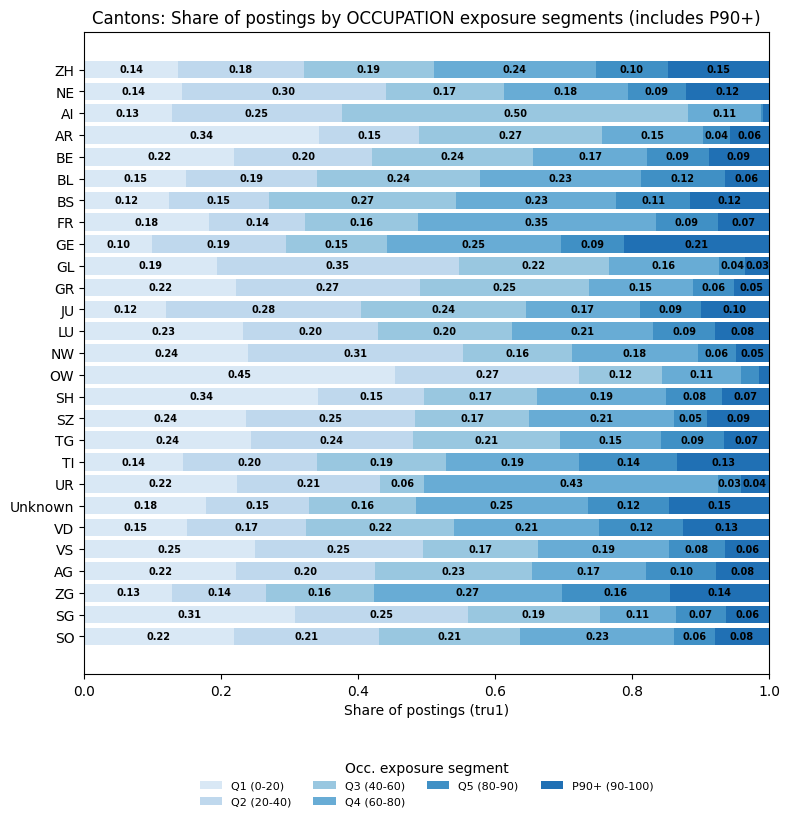

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_kanton_stack_segments_occ_exp.png


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/2968864604.py:138: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(


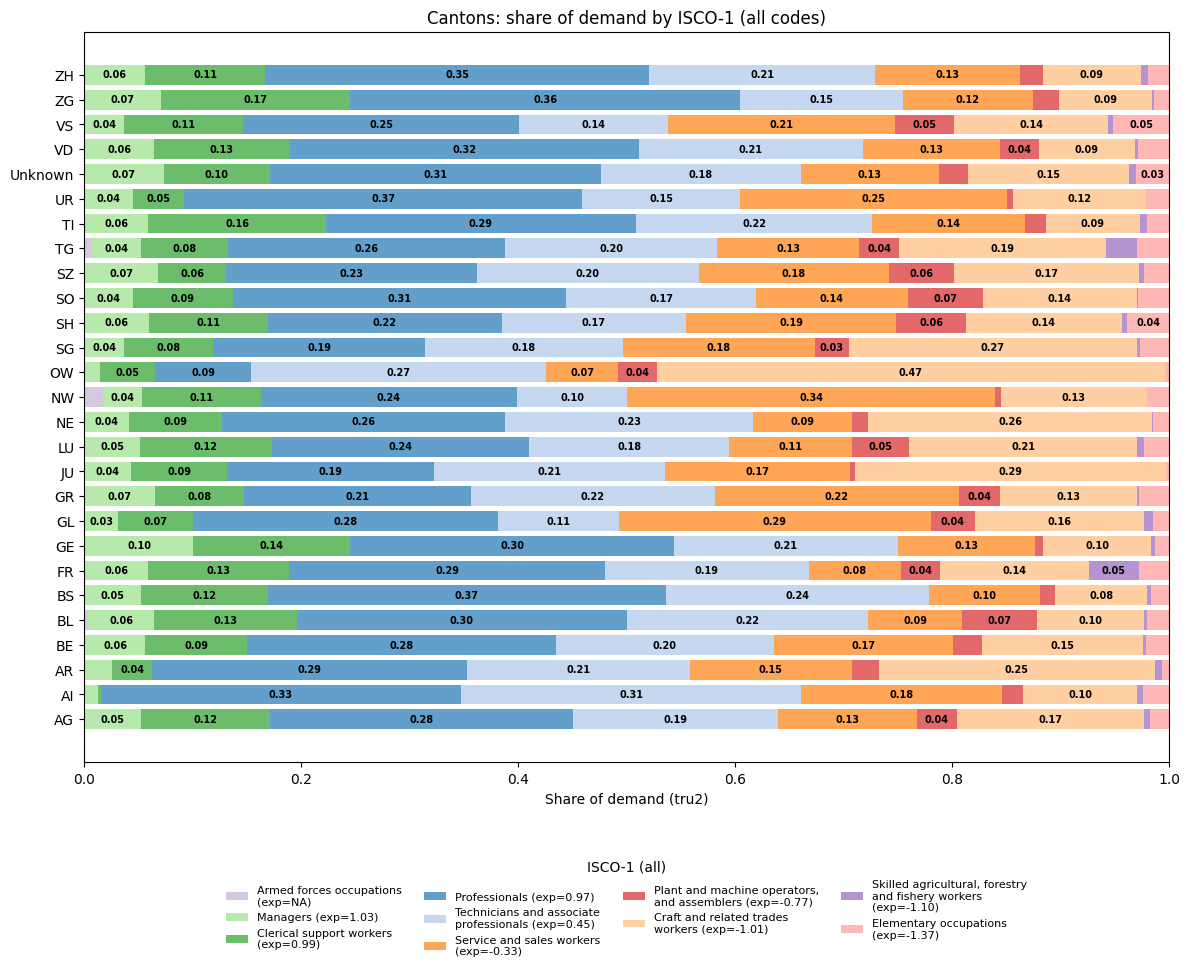

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_kanton_stack_isco1_share.png


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/2968864604.py:194: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(


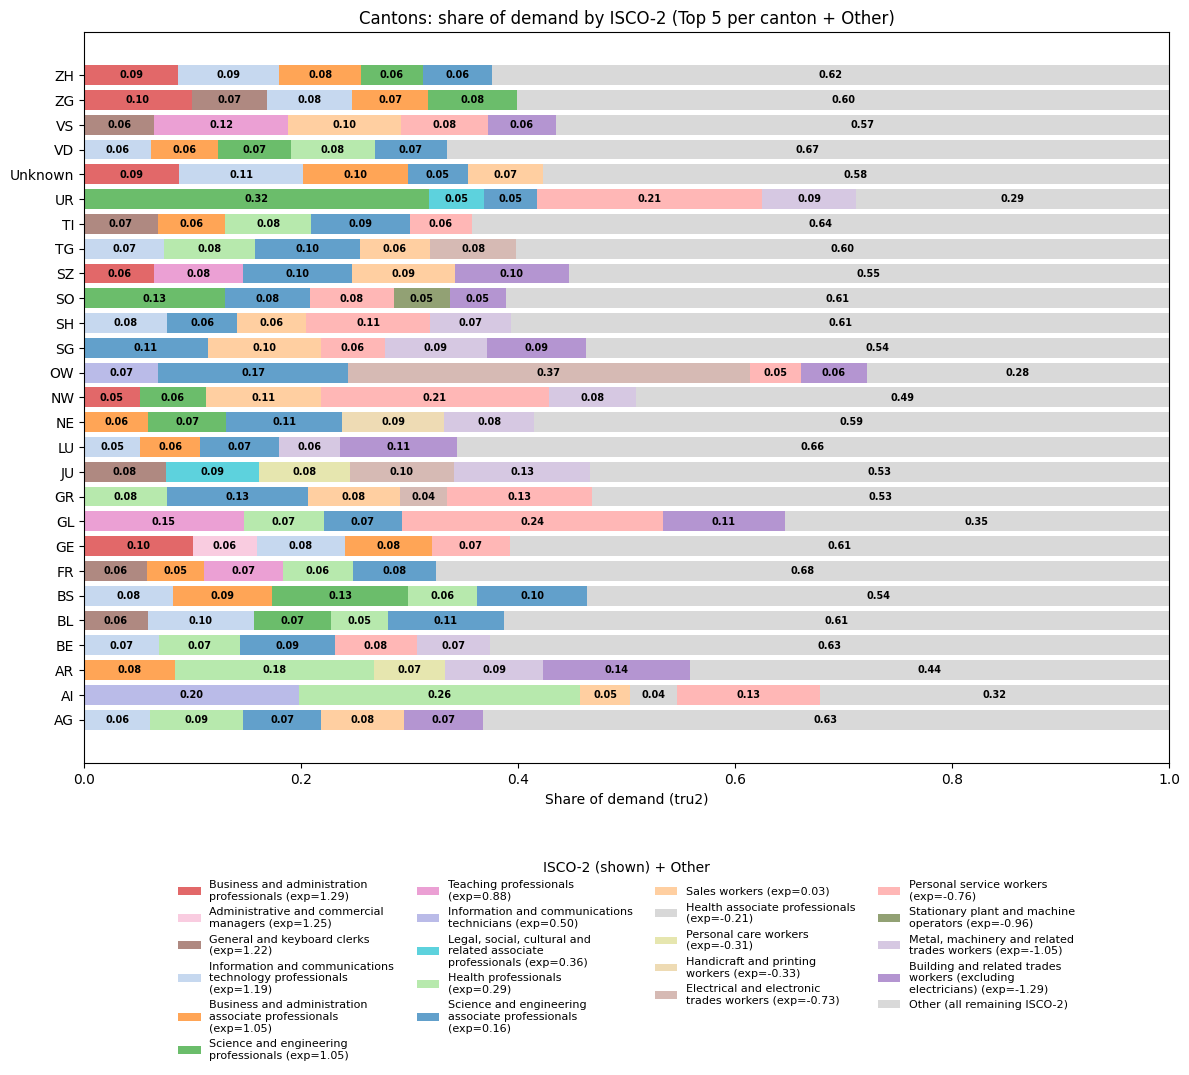

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_kanton_stack_isco2_share.png


In [ ]:
# === Occupation exposure segments + ISCO shares by canton ===
import textwrap

# helper for labels with exposure in label
import re

def _exp_from_label(lbl):
    m = re.search(r"exp=([+-]?\d*\.?\d+)", str(lbl))
    return float(m.group(1)) if m else float("nan")


def _legend_below(ax, handles=None, labels=None, title=None, ncol=4):
    if handles is None or labels is None:
        handles, labels = ax.get_legend_handles_labels()
    labels = [textwrap.fill(str(l), width=30) for l in labels]
    leg = ax.legend(handles, labels, title=title, ncol=ncol,
                    loc="upper center", bbox_to_anchor=(0.5, -0.12),
                    frameon=False, fontsize=8)
    return leg

# Ensure color maps exist (in case cells run out of order)
if "color_map_isco1" not in globals():
    from matplotlib import cm
    def _base_label(label):
        s = str(label)
        if ' (exp=' in s:
            s = s.split(' (exp=')[0]
        return s
    def _normalize_other(label, other_label="Other"):
        s = _base_label(label)
        if s.lower().startswith('other'):
            return other_label
        return s
    def build_color_map(labels, other_label="Other"):
        base = list(cm.get_cmap("tab20").colors) + list(cm.get_cmap("tab20b").colors) + list(cm.get_cmap("tab20c").colors)
        def mute(rgb, alpha=0.7):
            r, g, b = rgb[:3]
            return (alpha*r + (1-alpha)*1.0, alpha*g + (1-alpha)*1.0, alpha*b + (1-alpha)*1.0, 1.0)
        muted = [mute(c) for c in base]
        cmap = {}
        i = 0
        for lab in labels:
            lab_norm = _normalize_other(lab, other_label=other_label)
            if lab_norm == other_label or lab_norm in cmap:
                continue
            cmap[lab_norm] = muted[i % len(muted)]
            i += 1
        cmap[other_label] = (0.85, 0.85, 0.85, 1.0)
        return cmap
    def color_for_label(label, cmap, other_label="Other"):
        key = _normalize_other(label, other_label=other_label)
        return cmap.get(key, (0.85,0.85,0.85,1.0))

    def _ordered_labels_from_series(s):
        seen=set(); out=[]
        for lab in s.index:
            labn=_normalize_other(lab)
            if labn in seen: continue
            seen.add(labn); out.append(labn)
        return out

    isco1_order = (_df.groupby(_df['occu_isco1_label'].fillna('Unknown'))['srvy_wght_tru2'].sum().sort_values(ascending=False))
    isco2_order = (_df.groupby(_df['occu_isco2_label'].fillna('Unknown'))['srvy_wght_tru2'].sum().sort_values(ascending=False))
    color_map_isco1 = build_color_map(_ordered_labels_from_series(isco1_order), other_label='Other')
    color_map_isco2 = build_color_map(_ordered_labels_from_series(isco2_order), other_label='Other')

# --- Plot: share of postings by occupation exposure segments ---
# define segments using weighted thresholds

def _occ_segment(x):
    if pd.isna(x):
        return pd.NA
    if x <= occ_p20:
        return "Q1 (0-20)"
    if x <= occ_p40:
        return "Q2 (20-40)"
    if x <= occ_p60:
        return "Q3 (40-60)"
    if x <= occ_p80:
        return "Q4 (60-80)"
    if x < occ_p90:
        return "Q5 (80-90)"
    return "P90+ (90-100)"

_df["occ_exposure_segment"] = _df[occ_exp_col].apply(_occ_segment)
segments = ["Q1 (0-20)", "Q2 (20-40)", "Q3 (40-60)", "Q4 (60-80)", "Q5 (80-90)", "P90+ (90-100)"]

seg_df = _df[_df[region_col].notna() & _df["occ_exposure_segment"].notna()]
postings_per_kanton_segment = (
    seg_df.groupby([region_col, "occ_exposure_segment"], observed=True)["srvy_wght_tru1"].sum()
          .unstack(fill_value=0)
)
for seg in segments:
    if seg not in postings_per_kanton_segment.columns:
        postings_per_kanton_segment[seg] = 0

postings_per_kanton_segment_share = postings_per_kanton_segment.div(
    postings_per_kanton_segment.sum(axis=1), axis=0
)
postings_per_kanton_segment_share = postings_per_kanton_segment_share.loc[
    postings_per_kanton_segment_share.sum(axis=1) > 0
]

plot_order_occ = postings_per_kanton_segment_share.sum(axis=1).sort_values().index
postings_per_kanton_segment_share = postings_per_kanton_segment_share.loc[plot_order_occ]

fig, ax = plt.subplots(figsize=(8, 10))
colormap = plt.get_cmap("Blues")
segment_colors = [colormap(0.15 + 0.12*i) for i in range(len(segments))]

bottom = np.zeros(len(postings_per_kanton_segment_share))
y_labels = postings_per_kanton_segment_share.index.astype(str)
for i, seg in enumerate(segments):
    vals = postings_per_kanton_segment_share[seg].values
    bars = ax.barh(y_labels, vals, left=bottom, height=0.8, color=segment_colors[i], label=seg)
    for j, (bar, share) in enumerate(zip(bars, vals)):
        if np.isfinite(share) and share >= 0.03:
            ax.text(bottom[j] + share/2, bar.get_y() + bar.get_height()/2, f"{share:.2f}",
                    ha="center", va="center", color="black", fontsize=7, fontweight="bold")
    bottom += vals

ax.set_xlabel("Share of postings (tru1)")
ax.set_title("Cantons: Share of postings by OCCUPATION exposure segments (includes P90+)")
ax.set_xlim(0, 1)
_legend_below(ax, title="Occ. exposure segment", ncol=4)
plt.tight_layout()
plt.subplots_adjust(bottom=0.32)
fig_path = OUT_VIS / "fig_kanton_stack_segments_occ_exp.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# --- Plot: share of demand by ISCO-1 (all codes) ---
occ1_label = _df["occu_isco1_label"].fillna("Unknown")
occ1_exp_map = (
    _df.assign(_occ1=occ1_label)
       .groupby("_occ1", observed=True)
       .apply(lambda g: np.average(
           g.loc[g[occ_exp_col].notna(), occ_exp_col],
           weights=g.loc[g[occ_exp_col].notna(), "srvy_wght_tru2"]
       ) if g[occ_exp_col].notna().any() else np.nan)
)
occ1_label_exp = occ1_label.map(
    lambda lab: f"{lab} (exp={occ1_exp_map.get(lab, float('nan')):.2f})" if pd.notna(occ1_exp_map.get(lab, np.nan)) else f"{lab} (exp=NA)"
)

occ1_demand = (
    _df[_df[region_col].notna()]
      .assign(_occ1_label_exp=occ1_label_exp)
      .groupby([region_col, "_occ1_label_exp"], observed=True)["srvy_wght_tru2"].sum()
      .reset_index()
)

canton_totals = occ1_demand.groupby(region_col)["srvy_wght_tru2"].sum().rename("total").reset_index()
occ1_demand = occ1_demand.merge(canton_totals, on=region_col, how="left")
occ1_demand["share"] = occ1_demand["srvy_wght_tru2"] / occ1_demand["total"]

occ1_pivot = occ1_demand.pivot_table(index=region_col, columns="_occ1_label_exp", values="share", fill_value=0)

category_cols = occ1_pivot.columns.tolist()
category_cols = sorted(category_cols, key=_exp_from_label, reverse=True)
occ1_pivot = occ1_pivot[category_cols]

fig, ax = plt.subplots(figsize=(12, 12))
labels = occ1_pivot.index.astype(str)
colors = [color_for_label(cat, color_map_isco1) for cat in category_cols]

bottom = np.zeros(len(occ1_pivot))
for cat, color in zip(category_cols, colors):
    vals = occ1_pivot[cat].values
    bars = ax.barh(labels, vals, left=bottom, height=0.8, color=color, label=cat)
    for j, (bar, share) in enumerate(zip(bars, vals)):
        if np.isfinite(share) and share >= 0.03:
            ax.text(bottom[j] + share/2, bar.get_y() + bar.get_height()/2, f"{share:.2f}",
                    ha="center", va="center", color="black", fontsize=7, fontweight="bold")
    bottom += vals

ax.set_xlabel("Share of demand (tru2)")
ax.set_title("Cantons: share of demand by ISCO-1 (all codes)")
ax.set_xlim(0, 1)
_legend_below(ax, title="ISCO-1 (all)", ncol=4)
plt.tight_layout()
plt.subplots_adjust(bottom=0.36)
fig_path = OUT_VIS / "fig_kanton_stack_isco1_share.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# --- Plot: share of demand by ISCO-2 (Top 5 per canton + Other) ---
occ2_label = _df["occu_isco2_label"].fillna("Unknown")
occ2_exp_map = (
    _df.assign(_occ2=occ2_label)
       .groupby("_occ2", observed=True)
       .apply(lambda g: np.average(
           g.loc[g[occ_exp_col].notna(), occ_exp_col],
           weights=g.loc[g[occ_exp_col].notna(), "srvy_wght_tru2"]
       ) if g[occ_exp_col].notna().any() else np.nan)
)
occ2_label_exp = occ2_label.map(
    lambda lab: f"{lab} (exp={occ2_exp_map.get(lab, float('nan')):.2f})" if pd.notna(occ2_exp_map.get(lab, np.nan)) else f"{lab} (exp=NA)"
)

occ2_demand = (
    _df[_df[region_col].notna()]
      .assign(_occ2_label=occ2_label, _occ2_label_exp=occ2_label_exp)
      .groupby([region_col, "_occ2_label", "_occ2_label_exp"], observed=True)["srvy_wght_tru2"].sum()
      .reset_index()
)

canton_totals = occ2_demand.groupby(region_col)["srvy_wght_tru2"].sum().rename("total").reset_index()
occ2_demand = occ2_demand.merge(canton_totals, on=region_col, how="left")
occ2_demand["share"] = occ2_demand["srvy_wght_tru2"] / occ2_demand["total"]
occ2_demand["rank"] = occ2_demand.groupby(region_col)["share"].rank(method="first", ascending=False)
occ2_top = occ2_demand[occ2_demand["rank"] <= 5].copy()

occ2_pivot = occ2_top.pivot_table(index=region_col, columns="_occ2_label_exp", values="share", fill_value=0)
other_share = occ2_demand[occ2_demand["rank"] > 5].groupby(region_col)["share"].sum()
occ2_pivot["Other (all remaining ISCO-2)"] = other_share
occ2_pivot = occ2_pivot.fillna(0)

category_cols = occ2_pivot.columns.tolist()
other_col = "Other (all remaining ISCO-2)"
shown_cols = [c for c in category_cols if c != other_col]
shown_cols = sorted(shown_cols, key=_exp_from_label, reverse=True)
category_cols = shown_cols + ([other_col] if other_col in category_cols else [])
occ2_pivot = occ2_pivot[category_cols]

fig, ax = plt.subplots(figsize=(12, 12))
labels = occ2_pivot.index.astype(str)
colors = [color_for_label(cat, color_map_isco2) for cat in category_cols]

bottom = np.zeros(len(occ2_pivot))
for cat, color in zip(category_cols, colors):
    vals = occ2_pivot[cat].values
    bars = ax.barh(labels, vals, left=bottom, height=0.8, color=color, label=cat)
    for j, (bar, share) in enumerate(zip(bars, vals)):
        if np.isfinite(share) and share >= 0.03:
            ax.text(bottom[j] + share/2, bar.get_y() + bar.get_height()/2, f"{share:.2f}",
                    ha="center", va="center", color="black", fontsize=7, fontweight="bold")
    bottom += vals

ax.set_xlabel("Share of demand (tru2)")
ax.set_title("Cantons: share of demand by ISCO-2 (Top 5 per canton + Other)")
ax.set_xlim(0, 1)
_legend_below(ax, title="ISCO-2 (shown) + Other")
plt.tight_layout()
plt.subplots_adjust(bottom=0.36)
fig_path = OUT_VIS / "fig_kanton_stack_isco2_share.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)


### 6.2) Regions — industry exposure


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/1818306657.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_ind_exp_by_kanton = indreg_group.apply(wmean_industry_exp).reset_index(name="mean_ind_exp_tru2")


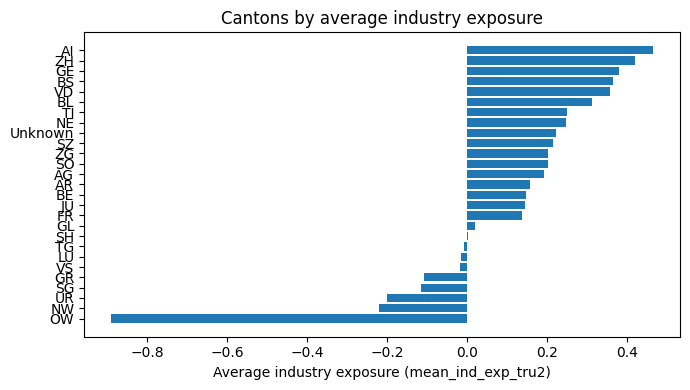

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_canton_top30_avg_industry_exposure.png


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/1818306657.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reg_metrics_ind["mean_ind_exp_tru2"] = ind_reg_group.apply(wmean_industry_exp)
/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/1818306657.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  known_denom_ind = ind_reg_group.apply(lambda g: g.loc[g[ind_exp_col].notn

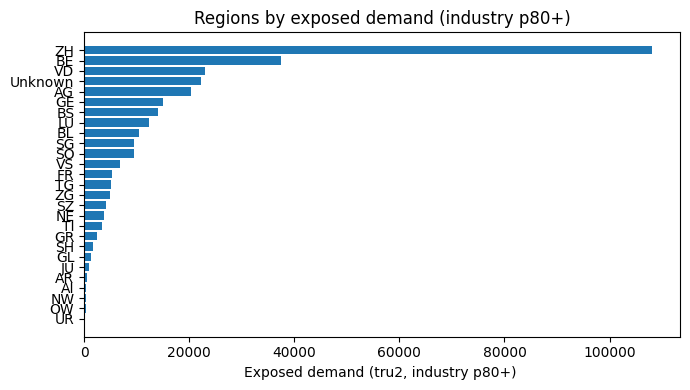

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top15_exposed_p80_ind.png


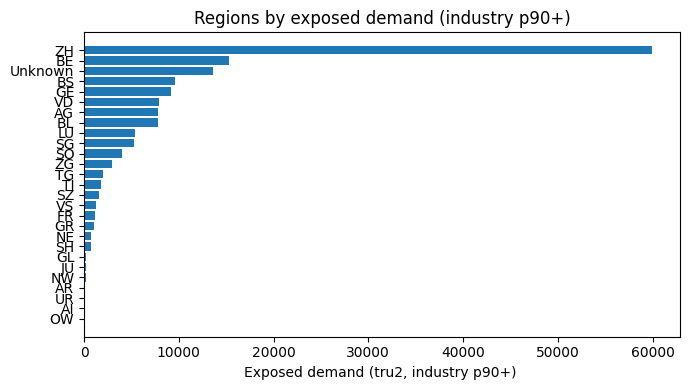

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top15_exposed_p90_ind.png


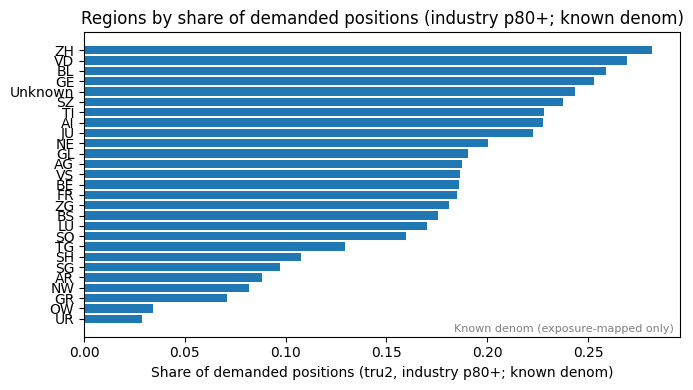

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top30_share_p80_ind.png


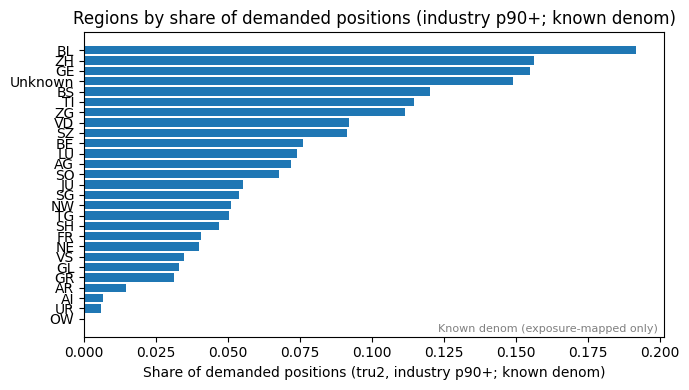

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_top30_share_p90_ind.png


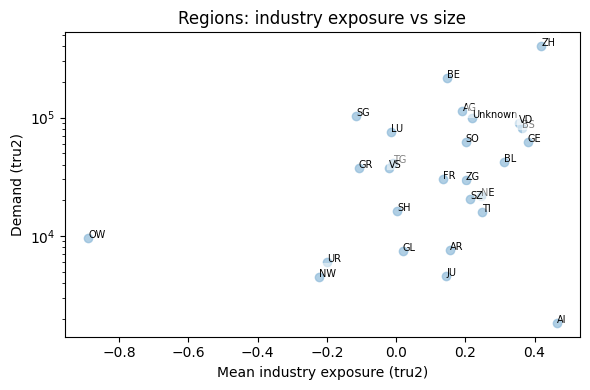

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_region_scatter_ind.png


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/1818306657.py:196: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(g[ind_exp_col].dropna(), weights=g.loc[g[ind_exp_col].notna(), "srvy_wght_tru2"])


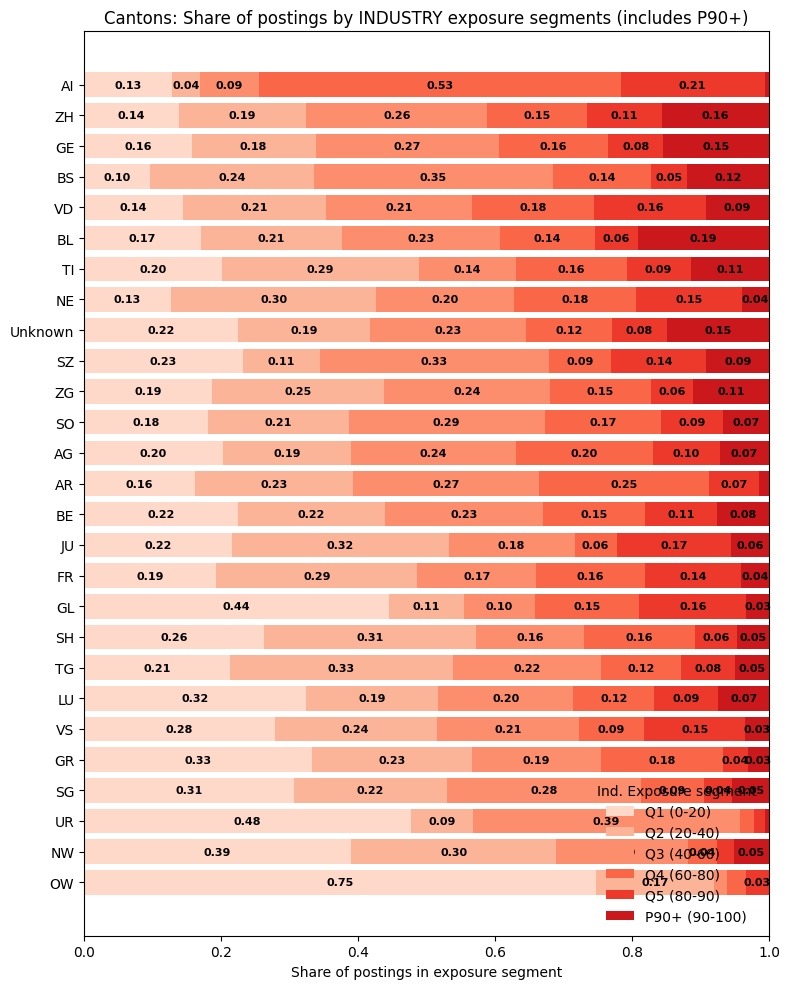

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_kanton_stack_segments_ind_exp.png


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/1818306657.py:262: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(


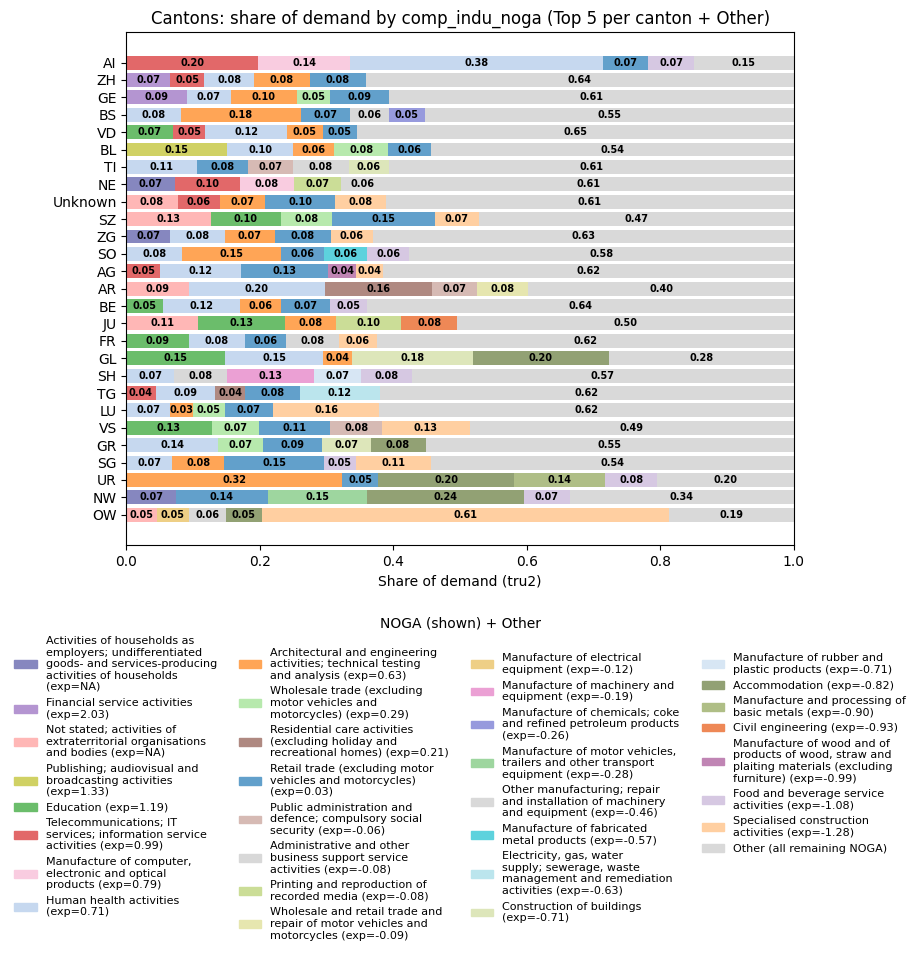

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_kanton_stack_comp_indu_noga_share.png


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/1818306657.py:372: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(
/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/1818306657.py:395: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(


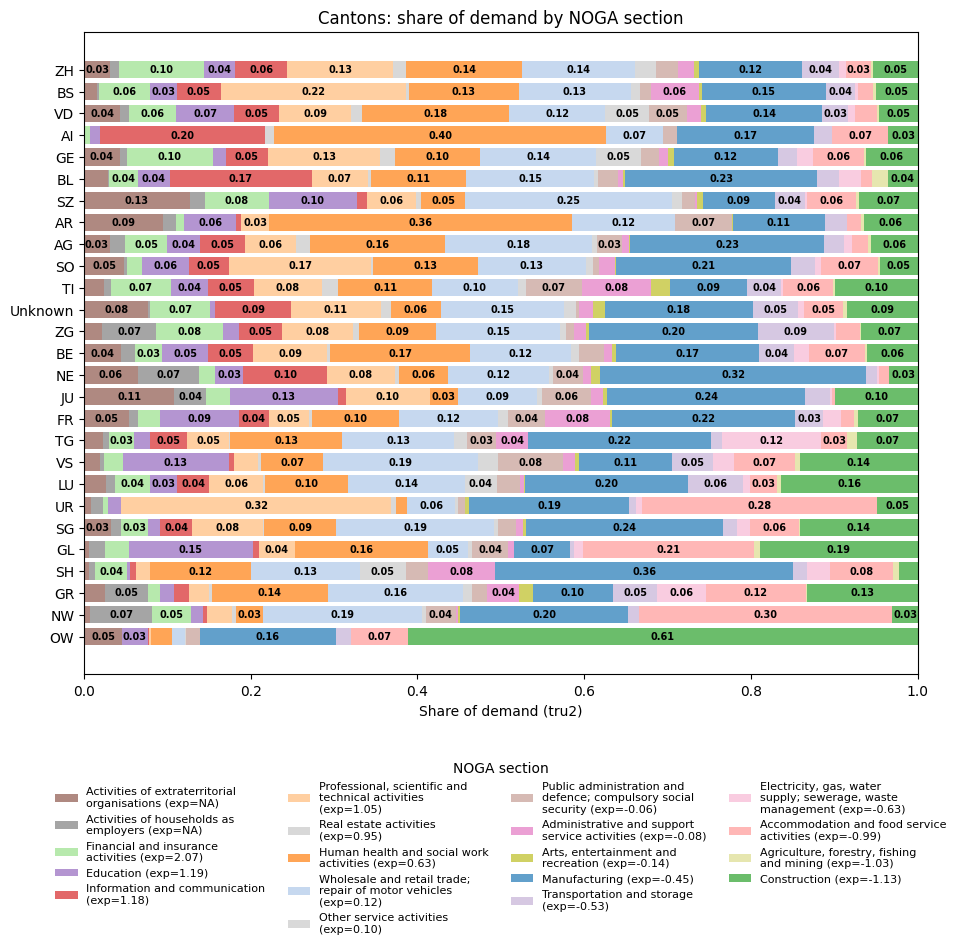

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_kanton_stack_section_share.png
Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/table_region_top5_industry_section.csv


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/1818306657.py:448: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


loca_regi_kant_label                                     _section_label  \
12                    AG                                      Manufacturing   
18                    AG  Wholesale and retail trade; repair of motor ve...   
10                    AG            Human health and social work activities   
14                    AG  Professional, scientific and technical activities   
6                     AG                                       Construction   
..                   ...                                                ...   
479                   ZH            Human health and social work activities   
487                   ZH  Wholesale and retail trade; repair of motor ve...   
483                   ZH  Professional, scientific and technical activities   
481                   ZH                                      Manufacturing   
478                   ZH                 Financial and insurance activities   

     demand_tru2  section_exposure_weighted  rank  
12    26627.2432                  -0.450426   1.0  
18    20155.1047                   0.120153   2.0  
10    18500.4375                   0.627138   3.0  
14     7022.3178                   1.047356   4.0  
6      6336.6923                  -1.128442   5.0  
..           ...                        ...   ...  
479   55916.5321                   0.627138   1.0  
487   54162.6313                   0.120153   2.0  
483   50844.5426                   1.047356   3.0  
481   49431.6736                  -0.450426   4.0  
478   41012.2152                   2.072848   5.0  

[135 rows x 5 columns]

In [ ]:
# ==== Plot: average industry exposure per canton ====
import textwrap
from matplotlib.patches import Patch

def _wrap_labels(labels, width=30):
    return [textwrap.fill(str(l), width=width) for l in labels]



import re

def _exp_from_label(lbl):
    m = re.search(r"exp=([+-]?\d*\.?\d+)", str(lbl))
    return float(m.group(1)) if m else float("nan")


def _legend_below(ax, handles=None, labels=None, title=None, ncol=4):
    if handles is None or labels is None:
        handles, labels = ax.get_legend_handles_labels()
    labels = _wrap_labels(labels, width=30)
    leg = ax.legend(handles, labels, title=title, ncol=ncol,
                    loc="upper center", bbox_to_anchor=(0.5, -0.12),
                    frameon=False, fontsize=8)
    return leg

# Compute weighted average industry exposure per canton
def wmean_industry_exp(g):
    x = g.loc[g[ind_exp_col].notna(), ind_exp_col]
    w = g.loc[g[ind_exp_col].notna(), "srvy_wght_tru2"]
    return np.average(x, weights=w) if len(x) else np.nan

indreg_group = _df.groupby(region_col)
avg_ind_exp_by_kanton = indreg_group.apply(wmean_industry_exp).reset_index(name="mean_ind_exp_tru2")

top_kanton_ind_exp = avg_ind_exp_by_kanton.nlargest(30, "mean_ind_exp_tru2")
plt.figure(figsize=(7,4))
plt.barh(top_kanton_ind_exp[region_col].astype(str), top_kanton_ind_exp["mean_ind_exp_tru2"])
plt.gca().invert_yaxis()
plt.xlabel("Average industry exposure (mean_ind_exp_tru2)")
plt.title("Cantons by average industry exposure")
plt.tight_layout()
fig_path = OUT_VIS / "fig_canton_top30_avg_industry_exposure.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)
# ==== End plot ====

# Region summary (industry exposure)
ind_reg_group = _df.groupby(region_col)

reg_metrics_ind = ind_reg_group.agg(
    demand_total_tru2=("srvy_wght_tru2","sum"),
    postings_total_tru1=("srvy_wght_tru1","sum")
)
reg_metrics_ind["mean_ind_exp_tru2"] = ind_reg_group.apply(wmean_industry_exp)

# exposed demand p80/p90 (industry)
reg_metrics_ind["exposed_demand_p80_ind"] = _df.loc[_df[ind_exp_col] >= ind_p80].groupby(region_col)["srvy_wght_tru2"].sum()
reg_metrics_ind["exposed_demand_p90_ind"] = _df.loc[_df[ind_exp_col] >= ind_p90].groupby(region_col)["srvy_wght_tru2"].sum()
reg_metrics_ind = reg_metrics_ind.fillna(0)

# shares
known_denom_ind = ind_reg_group.apply(lambda g: g.loc[g[ind_exp_col].notna(), "srvy_wght_tru2"].sum())
reg_metrics_ind["high_share_total_p80_ind"] = reg_metrics_ind["exposed_demand_p80_ind"] / reg_metrics_ind["demand_total_tru2"]
reg_metrics_ind["high_share_known_p80_ind"] = reg_metrics_ind["exposed_demand_p80_ind"] / known_denom_ind
reg_metrics_ind["coverage_share_ind"] = known_denom_ind / reg_metrics_ind["demand_total_tru2"]

reg_metrics_ind["high_share_total_p90_ind"] = reg_metrics_ind["exposed_demand_p90_ind"] / reg_metrics_ind["demand_total_tru2"]
reg_metrics_ind["high_share_known_p90_ind"] = reg_metrics_ind["exposed_demand_p90_ind"] / known_denom_ind
reg_metrics_ind = reg_metrics_ind.reset_index()
reg_metrics_ind.to_csv(OUT_TABLES / "table_region_summary_industry.csv", index=False)

# Bar charts: exposed demand p80/p90 (industry)
for thresh_label in ["p80","p90"]:
    col = f"exposed_demand_{thresh_label}_ind"
    top_reg = reg_metrics_ind.nlargest(30, col)
    plt.figure(figsize=(7,4))
    plt.barh(top_reg[region_col].astype(str), top_reg[col])
    plt.gca().invert_yaxis()
    plt.xlabel(f"Exposed demand (tru2, industry {thresh_label}+) ")
    plt.title(f"Regions by exposed demand (industry {thresh_label}+)")
    plt.tight_layout()
    fig_path = OUT_VIS / f"fig_region_top15_exposed_{thresh_label}_ind.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print("Saved", fig_path)

# Bar charts: share of demanded positions (industry)

for thresh_label in ["p80", "p90"]:
    share_col = f"high_share_known_{thresh_label}_ind"
    plot_data = reg_metrics_ind.copy()
    plot_data[region_col] = plot_data[region_col].fillna("Unknown")
    plot_data[share_col] = pd.to_numeric(plot_data[share_col], errors="coerce").fillna(0)
    top_reg_share = plot_data.nlargest(30, share_col)
    plt.figure(figsize=(7,4))
    plt.barh(top_reg_share[region_col].astype(str), top_reg_share[share_col])
    plt.gca().invert_yaxis()
    plt.xlabel(f"Share of demanded positions (tru2, industry {thresh_label}+; known denom)")
    plt.title(f"Regions by share of demanded positions (industry {thresh_label}+; known denom)")
    plt.text(0.99, 0.01, 'Known denom (exposure-mapped only)', transform=plt.gca().transAxes, ha='right', va='bottom', fontsize=8, color='gray')
    plt.tight_layout()
    fig_path = OUT_VIS / f"fig_region_top30_share_{thresh_label}_ind.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print("Saved", fig_path)





# Scatter (industry)
plt.figure(figsize=(6,4))
reg_ind_plot = _finite_for_plot(reg_metrics_ind, "mean_ind_exp_tru2", "demand_total_tru2", y_positive=True)
plt.scatter(reg_ind_plot["mean_ind_exp_tru2"], reg_ind_plot["demand_total_tru2"], alpha=0.7)
label_set = set()
label_set.update(reg_ind_plot.nlargest(30, "demand_total_tru2")[region_col].tolist())
label_set.update(reg_ind_plot.nlargest(30, "mean_ind_exp_tru2")[region_col].tolist())
if "Unknown" in reg_metrics_ind[region_col].values:
    label_set.add("Unknown")
for _, row in reg_ind_plot[reg_ind_plot[region_col].isin(label_set)].iterrows():
    plt.text(row["mean_ind_exp_tru2"], row["demand_total_tru2"], str(row[region_col]), fontsize=7,
             bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))
plt.xlabel("Mean industry exposure (tru2)")
plt.ylabel("Demand (tru2)")
plt.yscale("log")
plt.title("Regions: industry exposure vs size")
plt.tight_layout()
fig_path = OUT_VIS / "fig_region_scatter_ind.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# Decomposition: top 5 regions by exposed demand (industry p80)
reg_metrics_ind_sorted = reg_metrics_ind.sort_values("exposed_demand_p80_ind", ascending=False)
top_regions_ind = reg_metrics_ind_sorted.head(5)[region_col].tolist()
rows_occ_ind = []
rows_ind_ind = []
if "occ2_label" not in globals():
    occ2_label = _df["occu_isco2_label"].fillna("Unknown")
for reg in top_regions_ind:
    sub = _df[(_df[region_col] == reg) & (_df[ind_exp_col] >= ind_p80)]
    sub_occ = sub.groupby("occ2_label")["srvy_wght_tru2"].sum().sort_values(ascending=False).head(5)
    for rank, (code, val) in enumerate(sub_occ.items(), start=1):
        rows_occ_ind.append({"region": reg, "rank": rank, "occ2_label": code, "exposed_demand_tru2": val})
    sub_ind = sub.groupby(_df["comp_indu_noga_label"].fillna("Unknown"))["srvy_wght_tru2"].sum().sort_values(ascending=False).head(5)
    for rank, (code, val) in enumerate(sub_ind.items(), start=1):
        rows_ind_ind.append({"region": reg, "rank": rank, "indu_label": code, "exposed_demand_tru2": val})

pd.DataFrame(rows_occ_ind).to_csv(OUT_TABLES / "table_region_top_occ2_contrib_ind.csv", index=False)
pd.DataFrame(rows_ind_ind).to_csv(OUT_TABLES / "table_region_top_ind_contrib_ind.csv", index=False)



# === Plot: horizontal stacked bars for exposure segments per canton (INDUSTRY exposure, includes P90+) ===
# Build exposure segments using global p20/p40/p60/p80/p90 thresholds
ind_p20_seg, ind_p40_seg, ind_p60_seg = ind_p20, ind_p40, ind_p60
ind_p80_seg, ind_p90_seg = ind_p80, ind_p90

def _ind_segment(x):
    if pd.isna(x):
        return pd.NA
    if x <= ind_p20:
        return "Q1 (0-20)"
    if x <= ind_p40:
        return "Q2 (20-40)"
    if x <= ind_p60:
        return "Q3 (40-60)"
    if x <= ind_p80_seg:
        return "Q4 (60-80)"
    if x < ind_p90_seg:
        return "Q5 (80-90)"
    return "P90+ (90-100)"

_df["ind_exposure_segment"] = _df[ind_exp_col].apply(_ind_segment)
segments = ["Q1 (0-20)", "Q2 (20-40)", "Q3 (40-60)", "Q4 (60-80)", "Q5 (80-90)", "P90+ (90-100)"]

postings_per_kanton_segment_ind = (
    _df[_df[region_col].notna() & _df["ind_exposure_segment"].notna()]
    .groupby([region_col, "ind_exposure_segment"], observed=True)["srvy_wght_tru2"].sum()
    .unstack(fill_value=0)
)
for seg in segments:
    if seg not in postings_per_kanton_segment_ind.columns:
        postings_per_kanton_segment_ind[seg] = 0

postings_per_kanton_segment_share_ind = postings_per_kanton_segment_ind.div(
    postings_per_kanton_segment_ind.sum(axis=1), axis=0
)
postings_per_kanton_segment_share_ind = postings_per_kanton_segment_share_ind.loc[
    postings_per_kanton_segment_share_ind.sum(axis=1) > 0
]

mean_ind_exposure_by_kanton = (
    _df.groupby(region_col)
    .apply(lambda g: np.average(g[ind_exp_col].dropna(), weights=g.loc[g[ind_exp_col].notna(), "srvy_wght_tru2"])
           if g[ind_exp_col].notna().any() else 0)
)
plot_order_ind = mean_ind_exposure_by_kanton.loc[postings_per_kanton_segment_share_ind.index].sort_values(ascending=True).index.tolist()
postings_per_kanton_segment_share_ind = postings_per_kanton_segment_share_ind.loc[plot_order_ind]

fig, ax = plt.subplots(figsize=(8, 10))

colormap_ind = plt.get_cmap("Reds")
segment_colors = [colormap_ind(0.15 + 0.12*i) for i in range(len(segments))]

bottom = np.zeros(len(postings_per_kanton_segment_share_ind))
y_labels = postings_per_kanton_segment_share_ind.index.astype(str)

for i, seg in enumerate(segments):
    vals = postings_per_kanton_segment_share_ind[seg].values
    bars = ax.barh(
        y_labels,
        vals,
        left=bottom,
        height=0.8,
        color=segment_colors[i],
        label=seg
    )
    for j, (bar, share) in enumerate(zip(bars, vals)):
        if np.isfinite(share) and share >= 0.03:
            xpos = bottom[j] + share/2
            ypos = bar.get_y() + bar.get_height()/2
            ax.text(
                xpos,
                ypos,
                f"{share:.2f}",
                ha="center",
                va="center",
                color="black",
                fontsize=8,
                fontweight="bold"
            )
    bottom += vals

ax.set_xlabel("Share of postings in exposure segment")
ax.set_title("Cantons: Share of postings by INDUSTRY exposure segments (includes P90+)")
ax.set_xlim(0, 1)
ax.legend(title="Ind. Exposure segment", loc="lower right", frameon=False)
plt.tight_layout()

fig_path = OUT_VIS / "fig_kanton_stack_segments_ind_exp.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)










# === Plot: share of demand by comp_indu_noga (Top 5 per canton + Other) ===
comp_label = _df["comp_indu_noga_label"].fillna("Unknown").astype(str)

comp_exp_map = (
    _df.assign(_comp=comp_label)
       .groupby("_comp", observed=True)
       .apply(lambda g: np.average(
           g.loc[g[ind_exp_col].notna(), ind_exp_col],
           weights=g.loc[g[ind_exp_col].notna(), "srvy_wght_tru2"]
       ) if g[ind_exp_col].notna().any() else np.nan)
)

comp_label_exp = comp_label.map(
    lambda lab: f"{lab} (exp={comp_exp_map.get(lab, float('nan')):.2f})"
    if pd.notna(comp_exp_map.get(lab, np.nan)) else f"{lab} (exp=NA)"
)

comp_demand = (
    _df[_df[region_col].notna()]
      .assign(_comp_label=comp_label, _comp_label_exp=comp_label_exp)
      .groupby([region_col, "_comp_label", "_comp_label_exp"], observed=True)["srvy_wght_tru2"].sum()
      .reset_index()
)

canton_totals = comp_demand.groupby(region_col)["srvy_wght_tru2"].sum().rename("total").reset_index()
comp_demand = comp_demand.merge(canton_totals, on=region_col, how="left")
comp_demand["share"] = comp_demand["srvy_wght_tru2"] / comp_demand["total"]

comp_demand["rank"] = comp_demand.groupby(region_col)["share"].rank(method="first", ascending=False)
comp_top = comp_demand[comp_demand["rank"] <= 5].copy()

comp_pivot = comp_top.pivot_table(index=region_col, columns="_comp_label_exp", values="share", fill_value=0)

other_share = comp_demand[comp_demand["rank"] > 5].groupby(region_col)["share"].sum()
comp_pivot["Other (all remaining NOGA)"] = other_share
comp_pivot = comp_pivot.fillna(0)

try:
    plot_order_ind = avg_ind_exp_by_kanton.sort_values("mean_ind_exp_tru2")[region_col].astype(str).tolist()
    comp_pivot = comp_pivot.loc[[r for r in plot_order_ind if r in comp_pivot.index]]
except Exception:
    pass

fig, ax = plt.subplots(figsize=(9, 10))
category_cols = comp_pivot.columns.tolist()
other_col = "Other (all remaining NOGA)"
shown_cols = [c for c in category_cols if c != other_col]
shown_cols = sorted(shown_cols, key=_exp_from_label, reverse=True)
category_cols = shown_cols + ([other_col] if other_col in category_cols else [])
comp_pivot = comp_pivot[category_cols]
shown_cols = [c for c in category_cols if c != "Other (all remaining NOGA)"]

colors = [color_for_label(cat, color_map_comp_noga) for cat in category_cols]

bottom = np.zeros(len(comp_pivot))
y_labels = comp_pivot.index.astype(str)

for i, col in enumerate(category_cols):
    vals = comp_pivot[col].values
    bars = ax.barh(
        y_labels,
        vals,
        left=bottom,
        height=0.8,
        color=colors[i],
        label=col
    )
    for j, (bar, share) in enumerate(zip(bars, vals)):
        if np.isfinite(share) and share >= 0.03:
            ax.text(
                bottom[j] + share/2,
                bar.get_y() + bar.get_height()/2,
                f"{share:.2f}",
                ha="center",
                va="center",
                color="black",
                fontsize=7,
                fontweight="bold"
            )
    bottom += vals

ax.set_xlabel("Share of demand (tru2)")
ax.set_title("Cantons: share of demand by comp_indu_noga (Top 5 per canton + Other)")
ax.set_xlim(0, 1)
# Legend: only shown labels + Other
legend_handles = []
legend_labels = []
for col in shown_cols:
    legend_handles.append(Patch(color=color_for_label(col, color_map_comp_noga)))
    legend_labels.append(col)
legend_handles.append(Patch(color=color_for_label(other_col, color_map_comp_noga)))
legend_labels.append("Other (all remaining NOGA)")
_legend_below(ax, handles=legend_handles, labels=legend_labels, title="NOGA (shown) + Other")


all_labels = comp_demand[["_comp_label", "_comp_label_exp"]].drop_duplicates()
shown_labels = comp_top[["_comp_label", "_comp_label_exp"]].drop_duplicates()
not_shown = all_labels.merge(shown_labels, on=["_comp_label", "_comp_label_exp"], how="left", indicator=True)
not_shown = not_shown[not_shown["_merge"] == "left_only"].drop(columns=["_merge"]).sort_values("_comp_label")
not_shown["note"] = "Not in top 5 for any canton"


plt.tight_layout()
plt.subplots_adjust(bottom=0.45)
fig_path = OUT_VIS / "fig_kanton_stack_comp_indu_noga_share.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# === Plot: share of demand by NOGA section (stacked bars) ===
section_exp_col = "industry_section_exposure_weighted"
section_label = _df["industry_section_label"].fillna("Unknown")

sec_exp_map = (
    _df.assign(_sec=section_label)
       .groupby("_sec", observed=True)
       .apply(lambda g: np.average(
           g.loc[g[section_exp_col].notna(), section_exp_col],
           weights=g.loc[g[section_exp_col].notna(), "srvy_wght_tru2"]
       ) if g[section_exp_col].notna().any() else np.nan)
)
section_label_exp = section_label.map(
    lambda lab: f"{lab} (exp={sec_exp_map.get(lab, float('nan')):.2f})"
    if pd.notna(sec_exp_map.get(lab, np.nan)) else f"{lab} (exp=NA)"
)

section_by_kanton = (
    _df[_df[region_col].notna()]
      .assign(_section=section_label_exp)
      .groupby([region_col, "_section"], observed=True)["srvy_wght_tru2"].sum()
      .unstack(fill_value=0)
)

section_share = section_by_kanton.div(section_by_kanton.sum(axis=1), axis=0)
section_share = section_share.loc[section_share.sum(axis=1) > 0]

# Order by mean section exposure in canton if possible
mean_sec_exposure_by_kanton = (
    _df.groupby(region_col)
    .apply(lambda g: np.average(
        g[section_exp_col].dropna(),
        weights=g.loc[g[section_exp_col].notna(), "srvy_wght_tru2"]
    ) if g[section_exp_col].notna().any() else 0)
)
plot_order_sec = mean_sec_exposure_by_kanton.loc[section_share.index].sort_values(ascending=True).index.tolist()
section_share = section_share.loc[plot_order_sec]

fig, ax = plt.subplots(figsize=(10, 10))
labels = section_share.index.astype(str)
# ensure noga section color map exists
if 'color_map_noga_section' not in globals() or len(color_map_noga_section) <= 1:
    try:
        _label_col = 'industry_section_label' if 'industry_section_label' in _df.columns else 'noga_section_label'
        noga_section_order = (
            _df.groupby(_df[_label_col].fillna('Unknown'))['srvy_wght_tru2']
               .sum().sort_values(ascending=False)
        )
        color_map_noga_section = build_color_map(_ordered_labels_from_series(noga_section_order), other_label='Other')
    except Exception:
        pass
category_cols = section_share.columns.tolist()
category_cols = sorted(category_cols, key=_exp_from_label, reverse=True)
section_share = section_share[category_cols]
colors = [color_for_label(cat, color_map_noga_section) for cat in category_cols]

bottom = np.zeros(len(section_share))
for i, cat in enumerate(category_cols):
    vals = section_share[cat].values
    bars = ax.barh(labels, vals, left=bottom, height=0.8, color=colors[i], label=cat)
    for j, (bar, share) in enumerate(zip(bars, vals)):
        if np.isfinite(share) and share >= 0.03:
            ax.text(bottom[j] + share/2, bar.get_y() + bar.get_height()/2, f"{share:.2f}",
                    ha="center", va="center", color="black", fontsize=7, fontweight="bold")
    bottom += vals

ax.set_xlabel("Share of demand (tru2)")
ax.set_title("Cantons: share of demand by NOGA section")
ax.set_xlim(0, 1)
_legend_below(ax, title="NOGA section")
plt.tight_layout()
plt.subplots_adjust(bottom=0.32)
fig_path = OUT_VIS / "fig_kanton_stack_section_share.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# Top 5 industry sections by canton (show all cantons)
section_label_col = _df["industry_section_label"].fillna(_df["industry_section"]).fillna("Unknown")

section_group = (
    _df.assign(_section_label=section_label_col)
       .groupby([region_col, "_section_label"], observed=True)
       .apply(lambda g: pd.Series({
           "demand_tru2": g["srvy_wght_tru2"].sum(),
           "section_exposure_weighted": (
               np.average(g.loc[g["industry_section_exposure_weighted"].notna(), "industry_section_exposure_weighted"],
                          weights=g.loc[g["industry_section_exposure_weighted"].notna(), "srvy_wght_tru2"])
               if g["industry_section_exposure_weighted"].notna().any() else np.nan
           )
       }))
       .reset_index()
)

section_group["rank"] = section_group.groupby(region_col)["demand_tru2"].rank(method="first", ascending=False)
section_top5 = section_group[section_group["rank"] <= 5].copy()
section_top5 = section_top5.sort_values([region_col, "rank"])

section_top5.to_csv(OUT_TABLES / "table_region_top5_industry_section.csv", index=False)
print("Saved", OUT_TABLES / "table_region_top5_industry_section.csv")

# Show all rows (top 5 per canton)
display(section_top5)



### 6.3) Canton composition differences: High vs Low exposure (Δ-share)
- Compare mean canton composition shares between **High** and **Low** exposure cantons (terciles).
- Δ‑share = mean share (High) − mean share (Low); shown in percentage points.
- Positive = more prevalent in high‑exposure cantons; negative = more prevalent in low‑exposure cantons.


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/4069585206.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df[known].groupby(region_col).apply(
/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/4069585206.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: wmean(g[exp_col], g["srvy_wght_tru2"]))


group_label  mean_high_share  \
6                                        Construction         0.055296   
0           Accommodation and food service activities         0.036994   
12                                      Manufacturing         0.168021   
8   Electricity, gas, water supply; sewerage, wast...         0.006967   
7                                           Education         0.043511   
15  Public administration and defence; compulsory ...         0.029275   
3       Administrative and support service activities          0.01909   
2               Activities of households as employers         0.018093   
4           Agriculture, forestry, fishing and mining         0.003615   
13                           Other service activities         0.014995   
5                  Arts, entertainment and recreation         0.005739   
17                         Transportation and storage          0.03406   
16                             Real estate activities         0.009367   
1        Activities of extraterritorial organisations         0.043973   
18  Wholesale and retail trade; repair of motor ve...         0.138171   
14  Professional, scientific and technical activities         0.093004   
9                  Financial and insurance activities         0.053145   
11                      Information and communication         0.070541   
10            Human health and social work activities         0.156144   

    mean_low_share  delta_share_pp  rank  
6         0.137383       -8.208706     1  
0         0.102876       -6.588166     2  
12        0.190068       -2.204707     3  
8         0.024081       -1.711431     4  
7         0.053725       -1.021379     5  
15        0.034406       -0.513102     6  
3         0.022704       -0.361417     7  
2         0.020777       -0.268455     8  
4         0.003515        0.009951     9  
13        0.014445        0.054978    10  
5         0.003459         0.22799    11  
17        0.027947        0.611335    12  
16        0.002544        0.682319    13  
1          0.03097        1.300298    14  
18        0.122379        1.579175    15  
14        0.069444        2.355955    16  
9         0.026937         2.62077    17  
11         0.02075        4.979075    18  
10        0.091588        6.455519    19

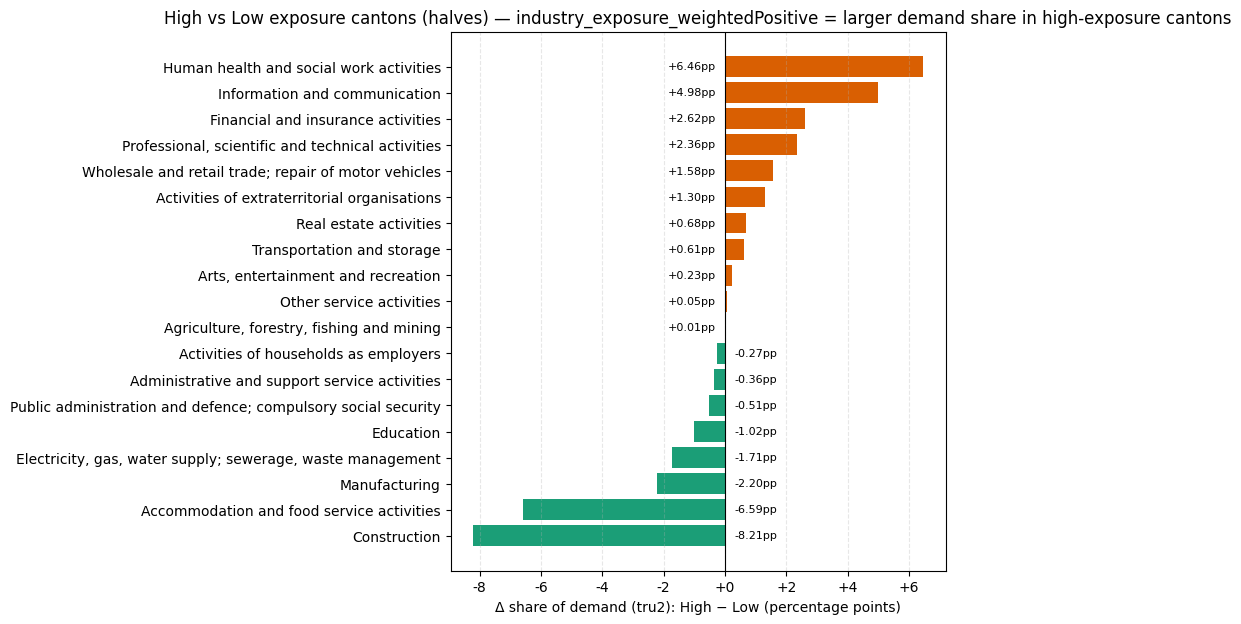

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_delta_share_noga_section_highlow_pretty.png


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/4069585206.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df[known].groupby(region_col).apply(
/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/4069585206.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: wmean(g[exp_col], g["srvy_wght_tru2"]))


group_label  mean_high_share  \
2                   Craft and related trades workers         0.124523   
7                          Service and sales workers         0.130143   
5        Plant and machine operators, and assemblers         0.029166   
3                             Elementary occupations          0.02017   
0                           Armed forces occupations         0.000792   
8  Skilled agricultural, forestry and fishery wor...         0.006493   
9            Technicians and associate professionals         0.198562   
4                                           Managers         0.058086   
1                           Clerical support workers         0.118196   
6                                      Professionals         0.313869   

   mean_low_share  delta_share_pp  rank  
2        0.204008        -7.94855     1  
7        0.186316       -5.617267     2  
5        0.036099       -0.693305     3  
3        0.022513       -0.234376     4  
0        0.002137       -0.134577     5  
8        0.005693        0.079967     6  
9        0.193573        0.498878     7  
4        0.040268        1.781853     8  
1        0.077525        4.067072     9  
6        0.231866        8.200306    10

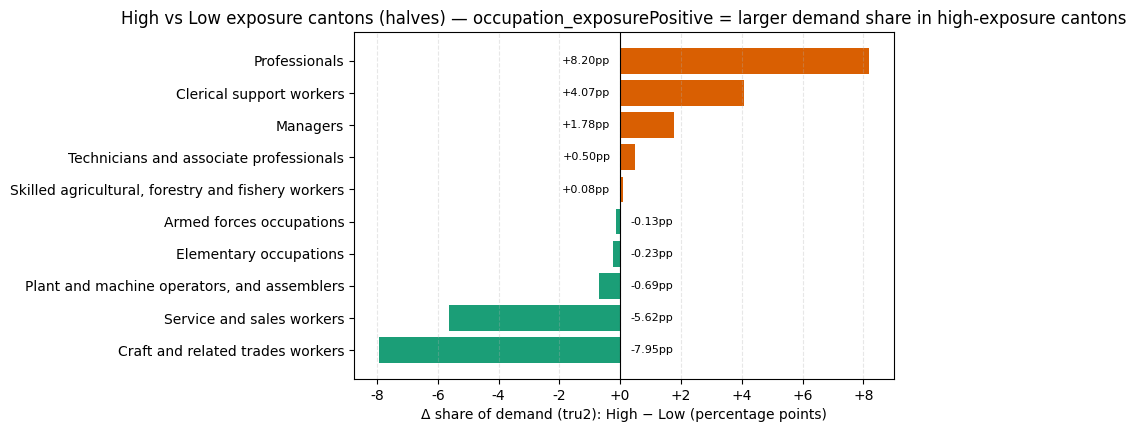

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_delta_share_isco1_highlow_pretty.png


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/4069585206.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df[known].groupby(region_col).apply(


group_label  mean_high_share  \
12           Electrical and electronic trades workers         0.024391   
31                           Personal service workers         0.057974   
4   Building and related trades workers (excluding...         0.036823   
39                             Teaching professionals         0.028724   
18                               Health professionals         0.054162   
35                                      Sales workers         0.047831   
20         Information and communications technicians         0.010564   
27        Metal, machinery and related trades workers         0.045571   
11                 Drivers and mobile plant operators         0.013277   
14  Food processing, woodworking, garment and othe...         0.005869   
30                              Personal care workers         0.015126   
36    Science and engineering associate professionals         0.075648   
3                                          Assemblers         0.002799   
2               Armed forces occupations, other ranks          0.00003   
7   Chief executives, senior officials and legisla...         0.006846   
34        Refuse workers and other elementary workers         0.003572   
13                        Food preparation assistants         0.002157   
22  Labourers in mining, construction, manufacturi...         0.005408   
8                                Cleaners and helpers         0.006073   
26  Market-oriented skilled forestry, fishery and ...         0.000152   
10                           Customer services clerks         0.011068   
9                  Commissioned armed forces officers         0.000012   
24  Legal, social, cultural and related associate ...         0.019656   
25       Market-oriented skilled agricultural workers         0.006348   
1        Agricultural, forestry and fishery labourers         0.002517   
19    Hospitality, retail and other services managers         0.004667   
32       Production and specialised services managers         0.017888   
38             Stationary plant and machine operators         0.013092   
33                        Protective services workers         0.009296   
17                     Health associate professionals         0.024038   
40               Unknown sub-major (major group only)         0.018637   
16                    Handicraft and printing workers         0.011437   
23           Legal, social and cultural professionals          0.02032   
29                     Other clerical support workers         0.028101   
28            Numerical and material recording clerks         0.030938   
0              Administrative and commercial managers         0.027591   
5   Business and administration associate professi...         0.057996   
15                        General and keyboard clerks         0.048157   
6           Business and administration professionals         0.055297   
21  Information and communications technology prof...         0.061353   
37              Science and engineering professionals           0.0886   

    mean_low_share  delta_share_pp  rank  
12        0.064207        -3.98157     1  
31        0.094277       -3.630251     2  
4         0.066867       -3.004446     3  
39        0.048891       -2.016721     4  
18        0.073293        -1.91313     5  
35        0.066635       -1.880476     6  
20        0.027803       -1.723896     7  
27        0.058445       -1.287338     8  
11        0.019953       -0.667602     9  
14        0.011606       -0.573795    10  
30        0.019967       -0.484122    11  
36         0.07892       -0.327139    12  
3         0.005884       -0.308515    13  
2         0.001372       -0.134265    14  
7         0.008056       -0.121042    15  
34        0.004723       -0.115129    16  
13        0.003302       -0.114491    17  
22        0.006338       -0.093026    18  
8         0.006903       -0.083027    19  
26        0.000454       -0.030229    20  
10        0.011333       -0.02

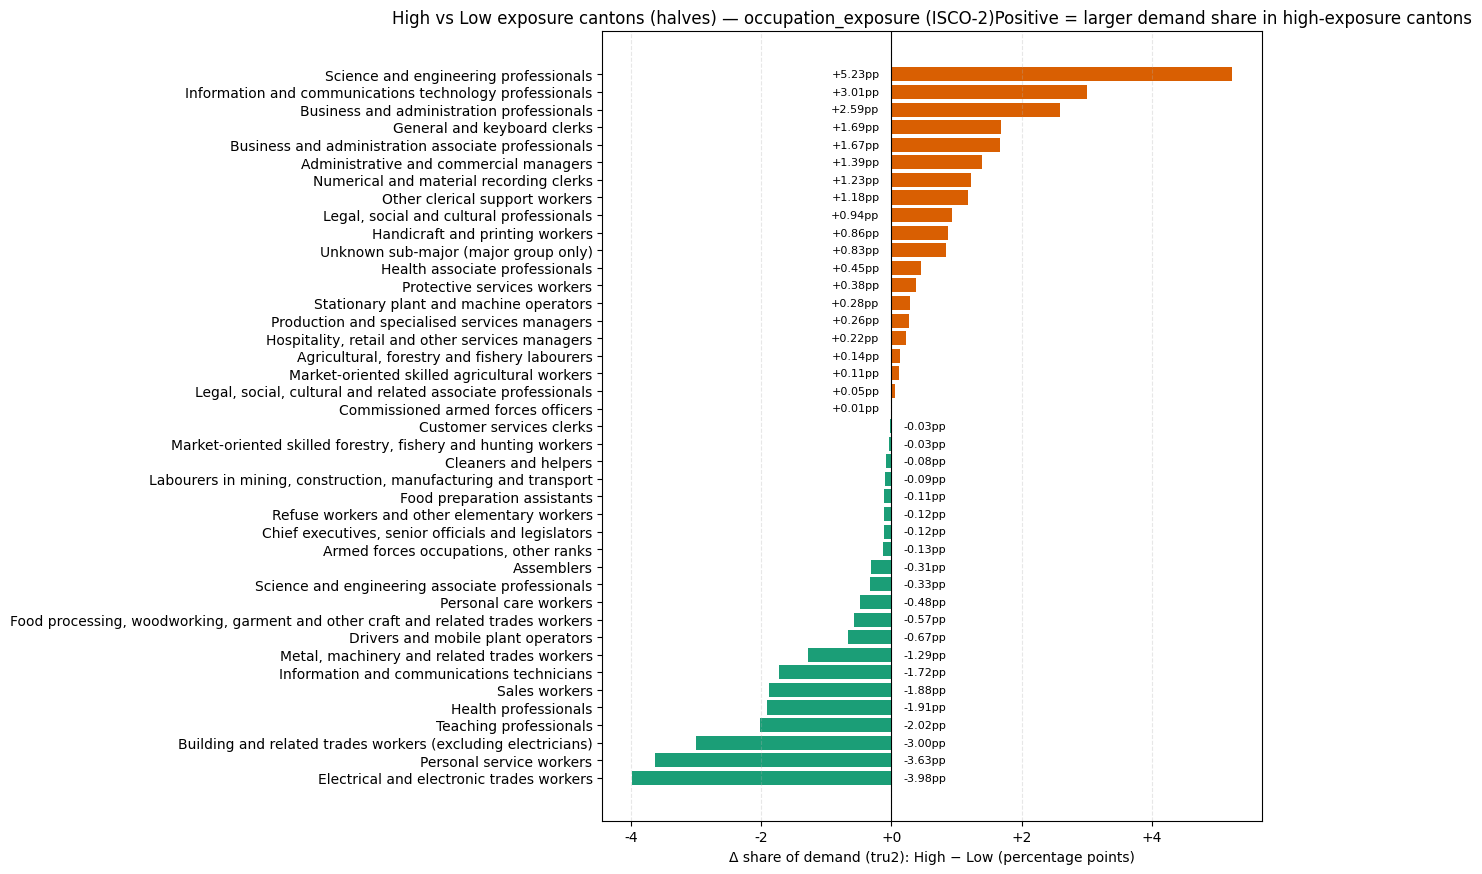

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_delta_share_isco2_highlow_pretty.png


In [ ]:

# --- Δ-share plots: High vs Low exposure cantons ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Display top/bottom groups (set to None to show all)
TOPK_NOGA = 8
TOPK_ISCO = 6


def wmean(series, weights):
    if series.empty:
        return np.nan
    return np.average(series, weights=weights)


def canton_exposure_scores(df, exp_col):
    known = df[exp_col].notna()
    return df[known].groupby(region_col).apply(
        lambda g: wmean(g[exp_col], g["srvy_wght_tru2"])
    )


def make_canton_shares(df, group_col):
    tmp = (
        df.groupby([region_col, group_col])["srvy_wght_tru2"].sum()
          .reset_index()
    )
    totals = tmp.groupby(region_col)["srvy_wght_tru2"].sum().rename("total").reset_index()
    tmp = tmp.merge(totals, on=region_col, how="left")
    tmp["share"] = tmp["srvy_wght_tru2"] / tmp["total"]
    pivot = tmp.pivot(index=region_col, columns=group_col, values="share").fillna(0)
    return pivot


def canton_group_exposure(df, group_col, exp_col):
    # exp_cg: weighted mean exposure within (canton, group), known exposure only
    tmp = df[df[exp_col].notna()].copy()
    tmp = (
        tmp.groupby([region_col, group_col])
           .apply(lambda g: wmean(g[exp_col], g["srvy_wght_tru2"]))
           .reset_index(name="exp_cg")
    )
    pivot = tmp.pivot(index=region_col, columns=group_col, values="exp_cg")
    return pivot


def high_low_groups(exposure_scores):
    # Drop Unknown canton
    if "Unknown" in exposure_scores.index:
        exposure_scores = exposure_scores.drop("Unknown")
    # Rank-based halves to handle ties (median split)
    ranks = exposure_scores.rank(method="first")
    half = pd.qcut(ranks, q=2, labels=["Low", "High"])
    return half


def delta_share_table(shares, group_assign):
    # Align
    shares = shares.loc[group_assign.index]
    high = shares.loc[group_assign == "High"]
    low = shares.loc[group_assign == "Low"]
    mean_high = high.mean(axis=0)
    mean_low = low.mean(axis=0)
    delta = (mean_high - mean_low) * 100  # percentage points
    out = pd.DataFrame({
        "group_label": delta.index,
        "mean_high_share": mean_high.values,
        "mean_low_share": mean_low.values,
        "delta_share_pp": delta.values,
    }).sort_values("delta_share_pp")
    out["rank"] = np.arange(1, len(out)+1)
    return out


def ensure_group_label(df):
    if 'group_label' in df.columns:
        return df
    name = df.index.name or 'index'
    df = df.reset_index().rename(columns={name: 'group_label'})
    return df


def plot_delta_bar(df_delta, title, subtitle, fig_name, figsize, left_adjust, topk=None, label_at_zero=False):
    if "group_label" not in df_delta.columns:
        df_delta = df_delta.copy()
        df_delta["group_label"] = df_delta.index.astype(str)
    # Select top/bottom
    if topk is not None and topk > 0:
        sel = pd.concat([df_delta.head(topk), df_delta.tail(topk)])
    else:
        sel = df_delta
    sel = sel.sort_values("delta_share_pp")

    fig, ax = plt.subplots(figsize=figsize)
    colors = ["#1b9e77" if v < 0 else "#d95f02" for v in sel["delta_share_pp"]]
    bars = ax.barh(sel["group_label"], sel["delta_share_pp"], color=colors)
    if label_at_zero:
        ax.set_yticklabels([])
        for bar, label, v in zip(bars, sel["group_label"], sel["delta_share_pp"]):
            y = bar.get_y() + bar.get_height() / 2
            x = 0
            ax.text(x + (0.2 if v >= 0 else -0.2), y, str(label),
                    va="center", ha="left" if v >= 0 else "right", fontsize=8)
    ax.axvline(0, color="black", lw=0.8)
    ax.grid(axis='x', linestyle='--', alpha=0.3)

    # Value labels near zero line, on opposite side of axis from bar
    rng = sel["delta_share_pp"].max() - sel["delta_share_pp"].min()
    xpad = 0.02 * rng if rng > 0 else 0.1
    for bar, v in zip(bars, sel["delta_share_pp"]):
        y = bar.get_y() + bar.get_height() / 2
        if v >= 0:
            x = -xpad
            ha = "right"
        else:
            x = xpad
            ha = "left"
        val = (0.01 if abs(v) < 0.01 else abs(v)) * (1 if v >= 0 else -1)
        ax.text(x, y, f"{val:+.2f}pp", va="center", ha=ha, fontsize=8)

    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:+.0f}"))
    ax.set_xlabel("Δ share of demand (tru2): High − Low (percentage points)")
    ax.set_title(title + "" + subtitle)

    fig.subplots_adjust(left=left_adjust)
    fig_path = OUT_VIS / fig_name
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print("Saved", fig_path)


def _align_cols(*series_list):
    # Align multiple Series on shared index (inner join)
    idx = series_list[0].index
    for s in series_list[1:]:
        idx = idx.intersection(s.index)
    return [s.reindex(idx) for s in series_list]



# === NOGA section Δ-share ===
noga_label_col = "industry_section_label" if "industry_section_label" in _df.columns else "noga_section_label"
noga_df = _df.copy()
# Remove Unknown category from predictors
noga_df = noga_df[noga_df[noga_label_col].notna()]
noga_df = noga_df[noga_df[noga_label_col] != "Unknown"]

ind_exp_scores = canton_exposure_scores(noga_df, ind_exp_col)
group_assign_ind = high_low_groups(ind_exp_scores)
noga_shares = make_canton_shares(noga_df, noga_label_col)
noga_shares = noga_shares.loc[group_assign_ind.index]

# group exposure within canton
noga_exp_cg = canton_group_exposure(noga_df, noga_label_col, ind_exp_col)
noga_exp_cg = noga_exp_cg.loc[group_assign_ind.index]

delta_noga.to_csv(OUT_TABLES / "table_canton_highlow_delta_share_noga_section.csv", index=False)

display(delta_noga)
plot_delta_bar(
    delta_noga,
    title="High vs Low exposure cantons (halves) — industry_exposure_weighted",
    subtitle="Positive = larger demand share in high‑exposure cantons",
    fig_name="fig_delta_share_noga_section_highlow_pretty.png",
    figsize=(11, 7),
    left_adjust=0.45,
    topk=None,
)


# === ISCO-1 Δ-share ===
isco_label_col = "occu_isco1_label" if "occu_isco1_label" in _df.columns else "occ1_label"
isco_df = _df.copy()
isco_df = isco_df[isco_df[isco_label_col].notna()]
isco_df = isco_df[isco_df[isco_label_col] != "Unknown"]

occ_exp_scores = canton_exposure_scores(isco_df, occ_exp_col)
group_assign_occ = high_low_groups(occ_exp_scores)
isco_shares = make_canton_shares(isco_df, isco_label_col)
isco_shares = isco_shares.loc[group_assign_occ.index]

# group exposure within canton
isco_exp_cg = canton_group_exposure(isco_df, isco_label_col, occ_exp_col)
isco_exp_cg = isco_exp_cg.loc[group_assign_occ.index]

delta_isco.to_csv(OUT_TABLES / "table_canton_highlow_delta_share_isco1.csv", index=False)

display(delta_isco)
plot_delta_bar(
    delta_isco,
    title="High vs Low exposure cantons (halves) — occupation_exposure",
    subtitle="Positive = larger demand share in high‑exposure cantons",
    fig_name="fig_delta_share_isco1_highlow_pretty.png",
    figsize=(9, 4.5),
    left_adjust=0.30,
    topk=None,
    label_at_zero=False,
)

# === ISCO-2 Δ-share ===
isco2_label_col = "occu_isco2_label" if "occu_isco2_label" in _df.columns else "occ2_label"
isco2_df = _df.copy()
isco2_df = isco2_df[isco2_df[isco2_label_col].notna()]
isco2_df = isco2_df[isco2_df[isco2_label_col] != "Unknown"]

occ2_exp_scores = canton_exposure_scores(isco2_df, occ_exp_col)
group_assign_occ2 = high_low_groups(occ2_exp_scores)
isco2_shares = make_canton_shares(isco2_df, isco2_label_col)
isco2_shares = isco2_shares.loc[group_assign_occ2.index]

delta_isco2 = delta_share_table(isco2_shares, group_assign_occ2)
delta_isco2 = ensure_group_label(delta_isco2)

fig_h_isco2 = max(6, 0.25 * len(delta_isco2))

delta_isco2.to_csv(OUT_TABLES / "table_canton_highlow_delta_share_isco2.csv", index=False)

display(delta_isco2)
plot_delta_bar(
    delta_isco2,
    title="High vs Low exposure cantons (halves) — occupation_exposure (ISCO‑2)",
    subtitle="Positive = larger demand share in high‑exposure cantons",
    fig_name="fig_delta_share_isco2_highlow_pretty.png",
    figsize=(11, fig_h_isco2),
    left_adjust=0.30,
    topk=None,
    label_at_zero=False,
)


### 6.4 Canton exposure changes over time
Period averages (tru2-weighted) for canton exposure by period, plus growth metrics.


In [ ]:


# Canton exposure changes over time (occupation + industry)

region_col = "loca_regi_kant_label" if "loca_regi_kant_label" in _df.columns else "loca_regi_kant"

periods = [(2010, 2014), (2015, 2019), (2020, 2024)]
period_labels = ["2010_2014", "2015_2019", "2020_2024"]


def _period_mask(df, start, end):
    return (df["adve_time_year"] >= start) & (df["adve_time_year"] <= end)


def _weighted_mean(group, exp_col):
    sub = group[group[exp_col].notna()]
    if sub.empty:
        return float('nan')
    w = sub["srvy_wght_tru2"]
    return (sub[exp_col] * w).sum() / w.sum() if w.sum() else float('nan')


def build_canton_table(exp_col, out_name):
    rows = []
    for (start, end), label in zip(periods, period_labels):
        g = _df[_period_mask(_df, start, end)].groupby(region_col)
        vals = g.apply(lambda x: _weighted_mean(x, exp_col)).rename(label)
        rows.append(vals)

    wide = pd.concat(rows, axis=1).reset_index()

    # growth metrics (percent change relative to |baseline|)
    p1, p2, p3 = period_labels
    def abs_change(a, b):
        if pd.isna(a) or pd.isna(b):
            return float('nan')
        return b - a
        if pd.isna(a) or pd.isna(b) or a == 0:
            return float('nan')
        return (b - a) / abs(a)

    wide["growth_p1_p2"] = wide.apply(lambda r: abs_change(r[p1], r[p2]), axis=1)
    wide["growth_p2_p3"] = wide.apply(lambda r: abs_change(r[p2], r[p3]), axis=1)
    wide["growth_p1_p3"] = wide.apply(lambda r: abs_change(r[p1], r[p3]), axis=1)
    wide["avg_growth"] = wide[["growth_p1_p2", "growth_p2_p3"]].mean(axis=1)

    wide.to_csv(OUT_TABLES / out_name, index=False)
    return wide

occ_canton_trends = build_canton_table(occ_exp_col, "table_canton_occ_exposure_trends.csv")
ind_canton_trends = build_canton_table(ind_exp_col, "table_canton_ind_exposure_trends.csv")

print("Saved", OUT_TABLES / "table_canton_occ_exposure_trends.csv")
print("Saved", OUT_TABLES / "table_canton_ind_exposure_trends.csv")

# show samples
print("Occupation exposure (sample):")
display(occ_canton_trends)
print("Industry exposure (sample):")
display(ind_canton_trends)


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/1589726875.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vals = g.apply(lambda x: _weighted_mean(x, exp_col)).rename(label)
/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/1589726875.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vals = g.apply(lambda x: _weighted_mean(x, exp_col)).rename(label)
/var/folders/b8/xc

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/table_canton_occ_exposure_trends.csv
Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/table_canton_ind_exposure_trends.csv
Occupation exposure (sample):


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/1589726875.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vals = g.apply(lambda x: _weighted_mean(x, exp_col)).rename(label)
/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/1589726875.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vals = g.apply(lambda x: _weighted_mean(x, exp_col)).rename(label)
/var/folders/b8/xc

loca_regi_kant_label  2010_2014  2015_2019  2020_2024  growth_p1_p2  \
0                    AG   0.220589   0.210772   0.138974     -0.009816   
1                    AI   0.331249  -0.289597  -0.037718     -0.620846   
2                    AR   0.090395   0.089796  -0.232912     -0.000599   
3                    BE   0.245799   0.200255   0.155266     -0.045544   
4                    BL   0.333029   0.213301   0.446486     -0.119728   
5                    BS   0.410382   0.471906   0.579551      0.061524   
6                    FR   0.360216   0.138795   0.325976     -0.221421   
7                    GE   0.724565   0.479092   0.410673     -0.245473   
8                    GL   0.314292  -0.332527   0.132933     -0.646819   
9                    GR   0.238640   0.078209   0.006685     -0.160431   
10                   JU   0.526125   0.485311  -0.073405     -0.040814   
11                   LU   0.160693   0.113024   0.190829     -0.047669   
12                   NE   0.460869   0.272695   0.119017     -0.188175   
13                   NW   0.251049   0.211374  -0.042528     -0.039675   
14                   OW  -0.319055  -0.164402  -0.529162      0.154653   
15                   SG  -0.068654   0.026844  -0.084098      0.095498   
16                   SH   0.010057   0.138521   0.034039      0.128464   
17                   SO   0.173810   0.104567   0.288616     -0.069243   
18                   SZ   0.011741   0.421301   0.014367      0.409560   
19                   TG   0.059824   0.105428   0.066912      0.045604   
20                   TI   0.110357   0.412618   0.546878      0.302260   
21                   UR  -0.357291  -0.299905   0.607460      0.057386   
22              Unknown   0.312711   0.436506   0.332501      0.123794   
23                   VD   0.379789   0.459841   0.362965      0.080052   
24                   VS  -0.024108   0.275788   0.257050      0.299895   
25                   ZG   0.633588   0.517500   0.548218     -0.116087   
26                   ZH   0.491737   0.481136   0.420434     -0.010602   

    growth_p2_p3  growth_p1_p3  avg_growth  
0      -0.071798     -0.081614   -0.040807  
1       0.251879     -0.368966   -0.184483  
2      -0.322708     -0.323307   -0.161654  
3      -0.044989     -0.090533   -0.045266  
4       0.233185      0.113457    0.056728  
5       0.107645      0.169170    0.084585  
6       0.187181     -0.034240   -0.017120  
7      -0.068419     -0.313892   -0.156946  
8       0.465460     -0.181359   -0.090680  
9      -0.071524     -0.231955   -0.115978  
10     -0.558716     -0.599531   -0.299765  
11      0.077805      0.030136    0.015068  
12     -0.153678     -0.341852   -0.170926  
13     -0.253902     -0.293577   -0.146788  
14     -0.364760     -0.210107   -0.105053  
15     -0.110942     -0.015444   -0.007722  
16     -0.104482      0.023982    0.011991  
17      0.184049      0.114807    0.057403  
18     -0.406934      0.002626    0.001313  
19     -0.038516      0.007087    0.003544  
20      0.134261      0.436521    0.218261  
21      0.907365      0.964751    0.482376  
22     -0.104005      0.019789    0.009895  
23     -0.096876     -0.016824   -0.008412  
24     -0.018737      0.281158    0.140579  
25      0.030718     -0.085370   -0.042685  
26     -0.060702     -0.071304   -0.035652

Industry exposure (sample):


loca_regi_kant_label  2010_2014  2015_2019  2020_2024  growth_p1_p2  \
0                    AG   0.098021   0.161598   0.302893      0.063577   
1                    AI   0.685104   0.212154   0.323800     -0.472949   
2                    AR   0.130581   0.277002   0.095927      0.146420   
3                    BE   0.026546   0.159102   0.236629      0.132556   
4                    BL   0.078105   0.069548   0.503163     -0.008557   
5                    BS   0.223582   0.323884   0.549144      0.100303   
6                    FR   0.103393   0.066920   0.205974     -0.036473   
7                    GE   0.605732   0.312612   0.293451     -0.293121   
8                    GL   0.284621  -0.127422   0.226580     -0.412043   
9                    GR  -0.080628  -0.180701  -0.048721     -0.100072   
10                   JU   0.313775  -0.078063   0.157527     -0.391838   
11                   LU  -0.082078  -0.015632   0.043174      0.066445   
12                   NE   0.228717   0.208548   0.280108     -0.020170   
13                   NW   0.260945  -0.128330  -0.454205     -0.389276   
14                   OW  -0.992525  -0.820488  -0.890390      0.172036   
15                   SG  -0.192598  -0.139450  -0.033933      0.053149   
16                   SH   0.017085   0.042762  -0.035530      0.025676   
17                   SO   0.088786   0.120993   0.402127      0.032206   
18                   SZ  -0.197581   0.411972   0.437863      0.609553   
19                   TG  -0.138417  -0.161263   0.179844     -0.022846   
20                   TI   0.075052   0.454838   0.236472      0.379786   
21                   UR  -0.521240  -0.585011   0.067958     -0.063772   
22              Unknown   0.081119   0.274959   0.297823      0.193840   
23                   VD   0.386083   0.423041   0.282363      0.036959   
24                   VS  -0.270464   0.220524   0.143632      0.490987   
25                   ZG   0.247550   0.302360   0.105754      0.054810   
26                   ZH   0.424996   0.472783   0.357726      0.047787   

    growth_p2_p3  growth_p1_p3  avg_growth  
0       0.141295      0.204872    0.102436  
1       0.111645     -0.361304   -0.180652  
2      -0.181075     -0.034655   -0.017327  
3       0.077528      0.210084    0.105042  
4       0.433615      0.425058    0.212529  
5       0.225260      0.325562    0.162781  
6       0.139054      0.102581    0.051290  
7      -0.019160     -0.312281   -0.156140  
8       0.354003     -0.058040   -0.029020  
9       0.131979      0.031907    0.015954  
10      0.235590     -0.156247   -0.078124  
11      0.058806      0.125252    0.062626  
12      0.071560      0.051391    0.025695  
13     -0.325874     -0.715150   -0.357575  
14     -0.069901      0.102135    0.051067  
15      0.105517      0.158666    0.079333  
16     -0.078292     -0.052616   -0.026308  
17      0.281134      0.313340    0.156670  
18      0.025891      0.635443    0.317722  
19      0.341107      0.318260    0.159130  
20     -0.218366      0.161420    0.080710  
21      0.652970      0.589198    0.294599  
22      0.022863      0.216704    0.108352  
23     -0.140678     -0.103720   -0.051860  
24     -0.076892      0.414096    0.207048  
25     -0.196607     -0.141797   -0.070898  
26     -0.115057     -0.067270   -0.033635

In [ ]:
# 6.4b Top 5 group share changes (pp) per canton: NOGA section + ISCO-2 (separate tables)

region_col = "loca_regi_kant_label" if "loca_regi_kant_label" in _df.columns else "loca_regi_kant"

period1 = (2010, 2014)
period2 = (2015, 2019)

noga_label_col = "industry_section_label" if "industry_section_label" in _df.columns else "noga_section_label"
isco2_label_col = "occu_isco2_label" if "occu_isco2_label" in _df.columns else "occ2_label"

# Helper to compute share table for a period

def period_group_shares(df, group_col, start, end):
    sub = df[(df['adve_time_year'] >= start) & (df['adve_time_year'] <= end)].copy()
    tmp = (
        sub.groupby([region_col, group_col])["srvy_wght_tru2"].sum()
        .reset_index()
    )
    totals = tmp.groupby(region_col)["srvy_wght_tru2"].sum().rename("total").reset_index()
    tmp = tmp.merge(totals, on=region_col, how="left")
    tmp["share"] = tmp["srvy_wght_tru2"] / tmp["total"]
    return tmp[[region_col, group_col, "share"]]


def top_abs_changes(df, group_col, label_prefix, topk=5):
    p1 = period_group_shares(df, group_col, *period1)
    p2 = period_group_shares(df, group_col, *period2)

    merged = p1.merge(p2, on=[region_col, group_col], how="outer", suffixes=("_p1", "_p2")).fillna(0)
    merged["delta_pp"] = (merged["share_p2"] - merged["share_p1"]) * 100

    rows = []
    for reg, g in merged.groupby(region_col):
        row = {region_col: reg}
        top = g.reindex(g["delta_pp"].abs().sort_values(ascending=False).index).head(topk)
        for i, (_, r) in enumerate(top.iterrows(), start=1):
            row[f"{label_prefix}_chg{i}"] = r[group_col]
            row[f"{label_prefix}_chg{i}_pp"] = r["delta_pp"]
        rows.append(row)

    return pd.DataFrame(rows)

# Industry (NOGA section)
if noga_label_col in _df.columns:
    noga_top5 = top_abs_changes(_df, noga_label_col, "noga", topk=5)
    noga_top5.to_csv(OUT_TABLES / "table_canton_top5_changes_noga_section.csv", index=False)
    print("Saved", OUT_TABLES / "table_canton_top5_changes_noga_section.csv")
    display(noga_top5)
else:
    print("NOGA section label column not found; skipped.")

# Occupations (ISCO-2)
if isco2_label_col in _df.columns:
    isco2_top5 = top_abs_changes(_df, isco2_label_col, "isco2", topk=5)
    isco2_top5.to_csv(OUT_TABLES / "table_canton_top5_changes_isco2.csv", index=False)
    print("Saved", OUT_TABLES / "table_canton_top5_changes_isco2.csv")
    display(isco2_top5)
else:
    print("ISCO-2 label column not found; skipped.")


Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/table_canton_top5_changes_noga_section.csv


loca_regi_kant_label                                          noga_chg1  \
0                    AG                                      Manufacturing   
1                    AI                      Information and communication   
2                    AR            Human health and social work activities   
3                    BE  Wholesale and retail trade; repair of motor ve...   
4                    BL  Wholesale and retail trade; repair of motor ve...   
5                    BS  Professional, scientific and technical activities   
6                    FR      Administrative and support service activities   
7                    GE  Professional, scientific and technical activities   
8                    GL          Accommodation and food service activities   
9                    GR          Accommodation and food service activities   
10                   JU  Professional, scientific and technical activities   
11                   LU                         Transportation and storage   
12                   NE  Professional, scientific and technical activities   
13                   NW                                      Manufacturing   
14                   OW                                       Construction   
15                   SG  Wholesale and retail trade; repair of motor ve...   
16                   SH                                      Manufacturing   
17                   SO            Human health and social work activities   
18                   SZ                                       Construction   
19                   TG  Electricity, gas, water supply; sewerage, wast...   
20                   TI                                       Construction   
21                   UR          Accommodation and food service activities   
22              Unknown                                      Manufacturing   
23                   VD  Wholesale and retail trade; repair of motor ve...   
24                   VS  Wholesale and retail trade; repair of motor ve...   
25                   ZG                 Financial and insurance activities   
26                   ZH            Human health and social work activities   

    noga_chg1_pp                                          noga_chg2  \
0       4.612641                                       Construction   
1     -39.476314                                      Manufacturing   
2      20.609433  Wholesale and retail trade; repair of motor ve...   
3       3.996205            Human health and social work activities   
4      13.434919            Human health and social work activities   
5      15.649544                                      Manufacturing   
6       8.568873                         Transportation and storage   
7     -15.161148                 Financial and insurance activities   
8      33.807190  Professional, scientific and technical activities   
9       9.882205            Human health and social work activities   
10    -27.320558                         Transportation and storage   
11    -11.266180  Wholesale and retail trade; repair of motor ve...   
12    -17.838337  Wholesale and retail trade; repair of motor ve...   
13     17.217680                 Financial and insurance activities   
14    -12.325654                                      Manufacturing   
15     -4.710496            Human health and social work activities   
16    -21.243534                           Other service activities   
17      6.928599          Accommodation and food service activities   
18    -17.491857  Wholesale and retail trade; repair of motor ve...   
19     12.814232          Accommodation and food service activities   
20     -9.956028            Human health and social work activities   
21     18.637905                                       Construction   
22      6.712931  Wholesale and retail trade; repair of motor ve...   
23     -9.423611            Human health and social work activities   
24     19.699199                           

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/table_canton_top5_changes_isco2.csv


loca_regi_kant_label                                         isco2_chg1  \
0                    AG                        General and keyboard clerks   
1                    AI         Information and communications technicians   
2                    AR                               Health professionals   
3                    BE    Science and engineering associate professionals   
4                    BL                               Health professionals   
5                    BS    Science and engineering associate professionals   
6                    FR  Information and communications technology prof...   
7                    GE  Business and administration associate professi...   
8                    GL                           Personal service workers   
9                    GR                           Personal service workers   
10                   JU                        General and keyboard clerks   
11                   LU  Building and related trades workers (excluding...   
12                   NE                                      Sales workers   
13                   NW                                      Sales workers   
14                   OW           Electrical and electronic trades workers   
15                   SG  Building and related trades workers (excluding...   
16                   SH                                         Assemblers   
17                   SO          Business and administration professionals   
18                   SZ  Building and related trades workers (excluding...   
19                   TG                           Personal service workers   
20                   TI  Building and related trades workers (excluding...   
21                   UR                           Personal service workers   
22              Unknown          Business and administration professionals   
23                   VD                               Health professionals   
24                   VS                                      Sales workers   
25                   ZG                                      Sales workers   
26                   ZH  Business and administration associate professi...   

    isco2_chg1_pp                                         isco2_chg2  \
0        3.894982  Building and related trades workers (excluding...   
1      -39.476314                           Personal service workers   
2       27.739088        Metal, machinery and related trades workers   
3       -4.238281                     Health associate professionals   
4       -6.204198  Information and communications technology prof...   
5        6.477725              Science and engineering professionals   
6       -6.282469                           Personal service workers   
7       -8.762165  Legal, social, cultural and related associate ...   
8       38.026295                             Teaching professionals   
9       10.586687                               Health professionals   
10      17.190169              Science and engineering professionals   
11       5.570965  Information and communications technology prof...   
12       9.330069              Science and engineering professionals   
13      32.635657          Business and administration professionals   
14      -8.960891                           Customer services clerks   
15      -7.220879                                      Sales workers   
16      -7.232895  Information and communications technology prof...   
17       4.034494                           Personal service workers   
18     -11.089382                                      Sales workers   
19      -5.910226               Unknown sub-major (major group only)   
20      -6.931199                     Health associate professionals   
21      20.402215  Legal, social, cultural and related associate ...   
22       4.770513                                      Sales workers   
23       6.083666  Information and communications technology prof...   
24      10.725795 

## 7) Trends (annual + rolling + binned)

/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_63859/470776467.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_stats)


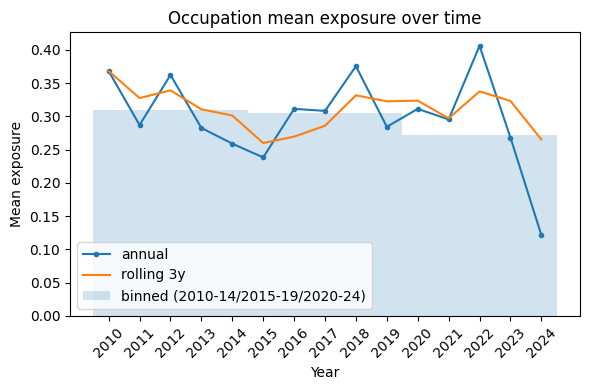

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_trend_occ_allviews.png


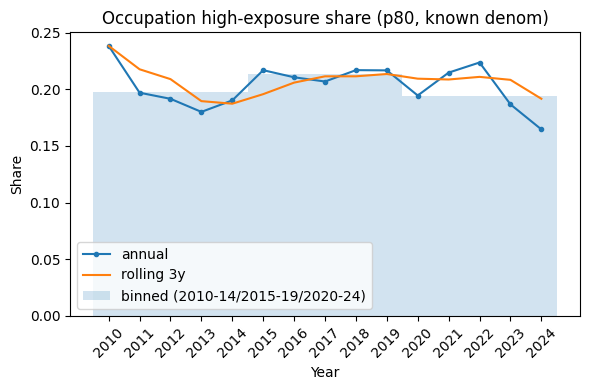

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_trend_occ_allviews_share.png


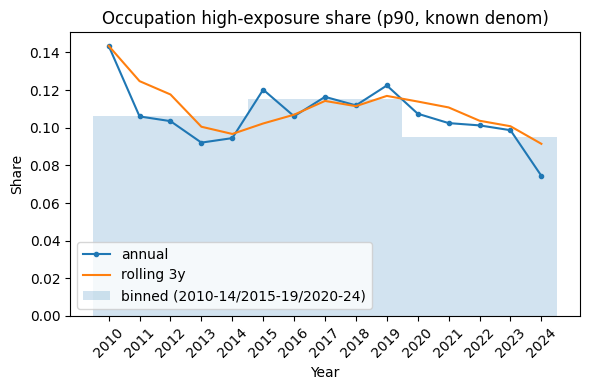

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_trend_occ_allviews_share_p90.png


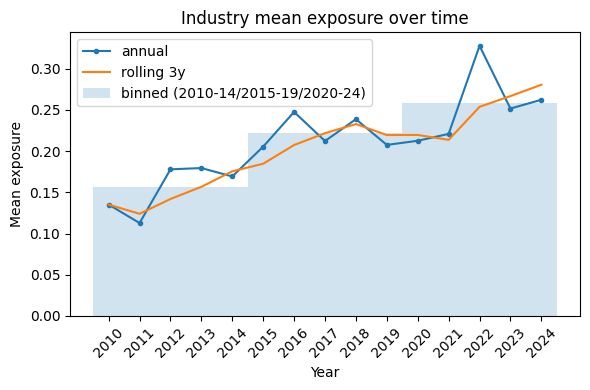

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_trend_ind_allviews.png


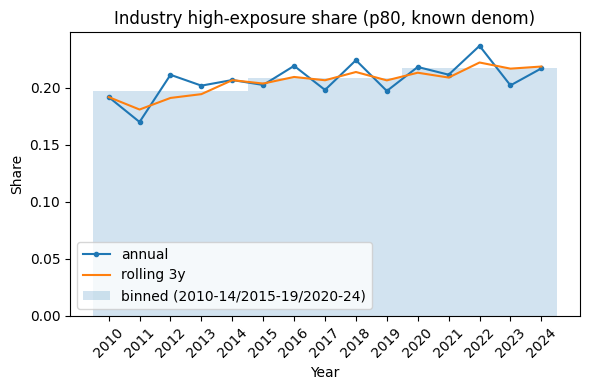

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_trend_ind_allviews_share.png


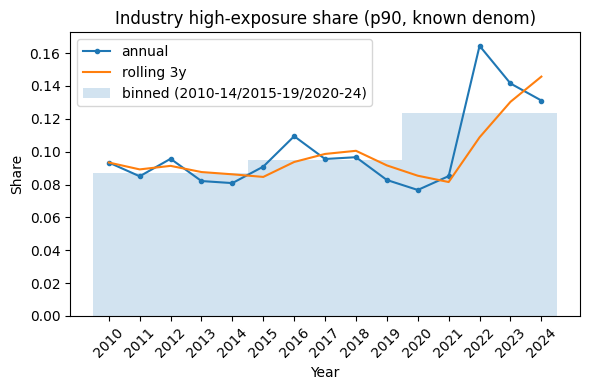

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_trend_ind_allviews_share_p90.png


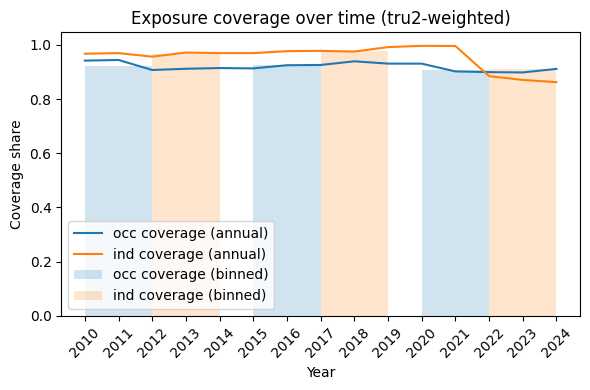

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_coverage_over_time.png


In [ ]:
# Annual series

def compute_stats(g):
    tot_tru2 = g['srvy_wght_tru2'].sum()
    occ_known = g[occ_exp_col].notna()
    ind_known = g[ind_exp_col].notna()
    occ_denom = g.loc[occ_known, 'srvy_wght_tru2'].sum()
    ind_denom = g.loc[ind_known, 'srvy_wght_tru2'].sum()
    return pd.Series({
        'occ_mean_exp': np.average(g.loc[occ_known, occ_exp_col], weights=g.loc[occ_known, 'srvy_wght_tru2']) if occ_denom else np.nan,
        'ind_mean_exp': np.average(g.loc[ind_known, ind_exp_col], weights=g.loc[ind_known, 'srvy_wght_tru2']) if ind_denom else np.nan,
        'occ_high_share_p80': g.loc[occ_known & (g[occ_exp_col] >= occ_p80), 'srvy_wght_tru2'].sum() / occ_denom if occ_denom else np.nan,
        'occ_high_share_p90': g.loc[occ_known & (g[occ_exp_col] >= occ_p90), 'srvy_wght_tru2'].sum() / occ_denom if occ_denom else np.nan,
        'ind_high_share_p80': g.loc[ind_known & (g[ind_exp_col] >= ind_p80), 'srvy_wght_tru2'].sum() / ind_denom if ind_denom else np.nan,
        'ind_high_share_p90': g.loc[ind_known & (g[ind_exp_col] >= ind_p90), 'srvy_wght_tru2'].sum() / ind_denom if ind_denom else np.nan,
        'occ_coverage': occ_denom / tot_tru2 if tot_tru2 else np.nan,
        'ind_coverage': ind_denom / tot_tru2 if tot_tru2 else np.nan,
    })

trend_annual = (
    _df.groupby('adve_time_year')
    .apply(compute_stats)
    .reset_index()
    .rename(columns={'adve_time_year': 'year'})
    .sort_values('year')
)
trend_annual.to_csv(OUT_TABLES / "table_trends_annual.csv", index=False)

# Rolling 3y
trend_roll = trend_annual.set_index('year').rolling(window=3, min_periods=1).mean().reset_index()
trend_roll.to_csv(OUT_TABLES / "table_trends_rolling3y.csv", index=False)

# Binned (2010-2014, 2015-2019, 2020-2024)
_bins = [(2010, 2014), (2015, 2019), (2020, 2024)]
rows = []
for start, end in _bins:
    g = _df[(_df['adve_time_year'] >= start) & (_df['adve_time_year'] <= end)]
    if g.empty:
        continue
    row = compute_stats(g).to_dict()
    row['period'] = f"{start}-{end}"
    row['start'] = start
    row['end'] = end
    rows.append(row)
trend_binned = pd.DataFrame(rows)
trend_binned.to_csv(OUT_TABLES / "table_trends_binned3bins.csv", index=False)


def _plot_with_bins(col, title, ylabel, fig_name):
    plt.figure(figsize=(6,4))
    plt.plot(trend_annual['year'], trend_annual[col], label='annual', marker='o', ms=3)
    plt.plot(trend_roll['year'], trend_roll[col], label='rolling 3y')
    if not trend_binned.empty:
        mids = (trend_binned['start'] + trend_binned['end']) / 2
        widths = (trend_binned['end'] - trend_binned['start'] + 1)
        plt.bar(mids, trend_binned[col], width=widths, alpha=0.2,
                label='binned (2010-14/2015-19/2020-24)')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.legend()
    plt.xticks(trend_annual['year'], rotation=45)
    plt.tight_layout()
    fig_path = OUT_VIS / fig_name
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print('Saved', fig_path)

# Plots: occ
_plot_with_bins('occ_mean_exp', 'Occupation mean exposure over time', 'Mean exposure', 'fig_trend_occ_allviews.png')
_plot_with_bins('occ_high_share_p80', 'Occupation high-exposure share (p80, known denom)', 'Share', 'fig_trend_occ_allviews_share.png')
_plot_with_bins('occ_high_share_p90', 'Occupation high-exposure share (p90, known denom)', 'Share', 'fig_trend_occ_allviews_share_p90.png')

# Plots: ind
_plot_with_bins('ind_mean_exp', 'Industry mean exposure over time', 'Mean exposure', 'fig_trend_ind_allviews.png')
_plot_with_bins('ind_high_share_p80', 'Industry high-exposure share (p80, known denom)', 'Share', 'fig_trend_ind_allviews_share.png')
_plot_with_bins('ind_high_share_p90', 'Industry high-exposure share (p90, known denom)', 'Share', 'fig_trend_ind_allviews_share_p90.png')

# Coverage over time (lines + binned bars)
plt.figure(figsize=(6,4))
plt.plot(trend_annual['year'], trend_annual['occ_coverage'], label='occ coverage (annual)')
plt.plot(trend_annual['year'], trend_annual['ind_coverage'], label='ind coverage (annual)')
if not trend_binned.empty:
    mids = (trend_binned['start'] + trend_binned['end']) / 2
    widths = (trend_binned['end'] - trend_binned['start'] + 1)
    plt.bar(mids - widths*0.2, trend_binned['occ_coverage'], width=widths*0.4, alpha=0.2, label='occ coverage (binned)')
    plt.bar(mids + widths*0.2, trend_binned['ind_coverage'], width=widths*0.4, alpha=0.2, label='ind coverage (binned)')
plt.title('Exposure coverage over time (tru2-weighted)')
plt.xlabel('Year')
plt.ylabel('Coverage share')
plt.legend()
plt.xticks(trend_annual['year'], rotation=45)
plt.tight_layout()
fig_path = OUT_VIS / "fig_coverage_over_time.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)


## 8) Industry vs occupation exposure (correlation + bubble)

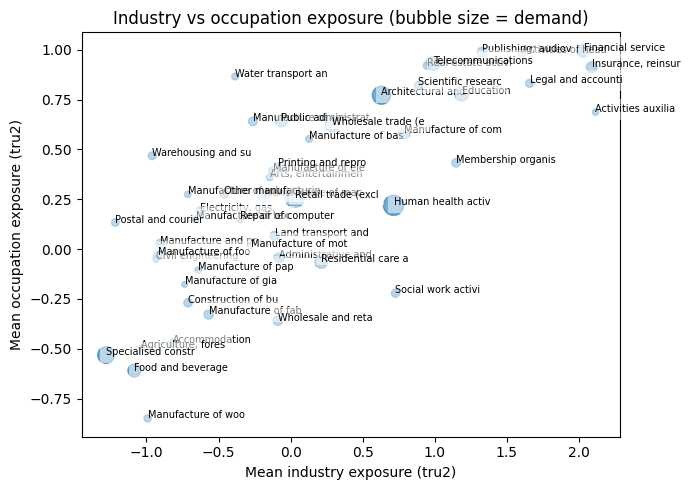

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_ind_vs_occ_exposure_bubble.png
Pearson: 0.7389407993948134
Spearman: 0.7388775510204082
Weighted Pearson: 0.8005239884029244
Demand vs ind exposure Pearson: 0.18374627860609496
Demand vs ind exposure Spearman: 0.32357142857142857
Demand vs ind exposure Weighted Pearson: 0.10154224398132866
Demand vs occ exposure Pearson: 0.09449938433922589
Demand vs occ exposure Spearman: 0.15775510204081633
Demand vs occ exposure Weighted Pearson: 0.0034753956328008526


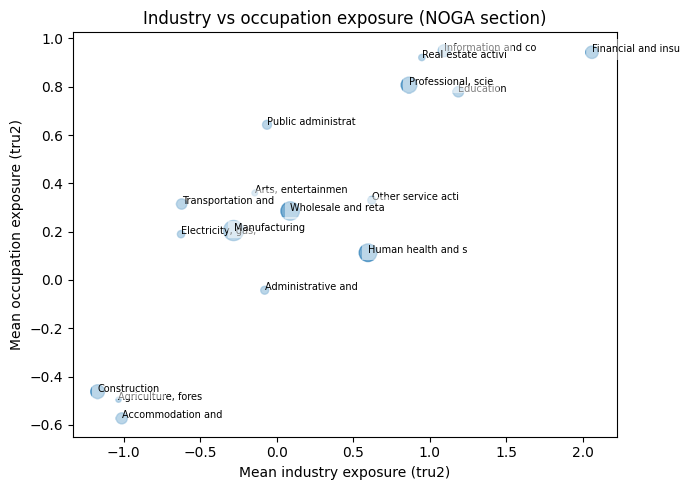

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_ind_vs_occ_exposure_bubble_noga_section.png
noga_section Pearson: 0.8533950670974755
noga_section Spearman: 0.8406862745098039
noga_section Weighted Pearson: 0.844867571648986
noga_section Demand vs ind exposure Pearson: 0.09431413601243581
noga_section Demand vs ind exposure Spearman: 0.18872549019607843
noga_section Demand vs ind exposure Weighted Pearson: -0.12643440831797798
noga_section Demand vs occ exposure Pearson: 0.004620884549593317
noga_section Demand vs occ exposure Spearman: 0.03676470588235294
noga_section Demand vs occ exposure Weighted Pearson: -0.1389746663561954


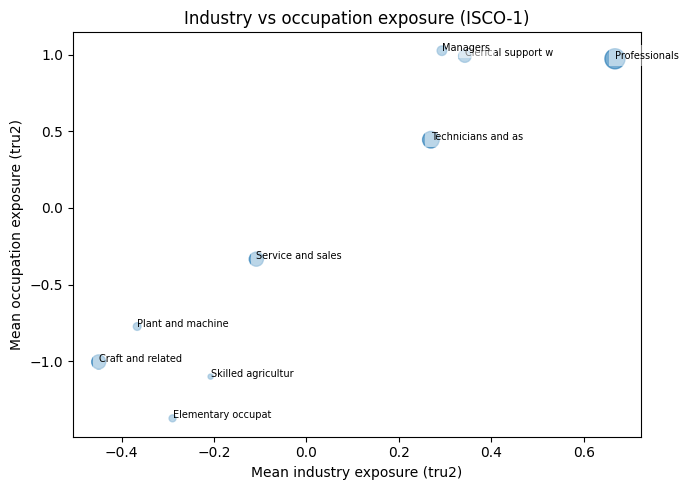

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_ind_vs_occ_exposure_bubble_isco1.png
isco1 Pearson: 0.9233389293078785
isco1 Spearman: 0.8
isco1 Weighted Pearson: 0.9465835516134468
isco1 Demand vs ind exposure Pearson: 0.6523140992123206
isco1 Demand vs ind exposure Spearman: 0.48333333333333334
isco1 Demand vs ind exposure Weighted Pearson: 0.730914332572693
isco1 Demand vs occ exposure Pearson: 0.5593074726592053
isco1 Demand vs occ exposure Spearman: 0.5166666666666667
isco1 Demand vs occ exposure Weighted Pearson: 0.5423773569109774


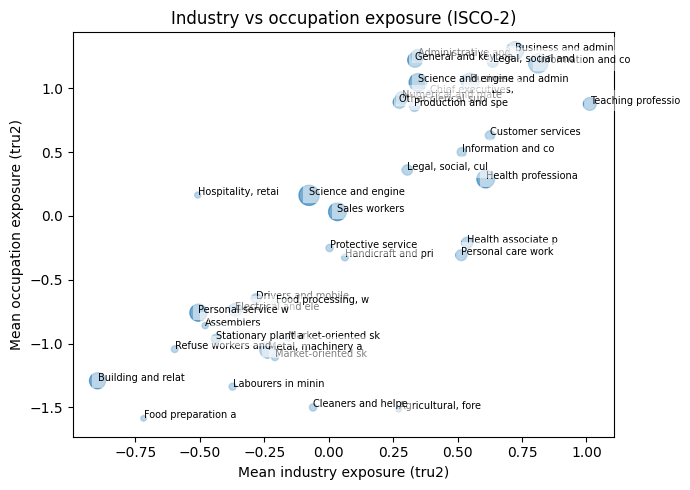

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_ind_vs_occ_exposure_bubble_isco2.png
isco2 Pearson: 0.7686049796011416
isco2 Spearman: 0.7667140825035562
isco2 Weighted Pearson: 0.8342760008179166
isco2 Demand vs ind exposure Pearson: 0.2837231944546775
isco2 Demand vs ind exposure Spearman: 0.422475106685633
isco2 Demand vs ind exposure Weighted Pearson: 0.09512478725530482
isco2 Demand vs occ exposure Pearson: 0.433456234992977
isco2 Demand vs occ exposure Spearman: 0.5410876463508042
isco2 Demand vs occ exposure Weighted Pearson: 0.2241757506558724


In [ ]:
# Industry-level mix
ind_mix = _df.groupby(_df["comp_indu_noga_label"].fillna("Unknown")).apply(
    lambda g: pd.Series({
        "demand_total_tru2": g["srvy_wght_tru2"].sum(),
        "mean_ind_exp": np.average(g[ind_exp_col].dropna(), weights=g.loc[g[ind_exp_col].notna(),"srvy_wght_tru2"]) if g[ind_exp_col].notna().any() else np.nan,
        "mean_occ_exp": np.average(g[occ_exp_col].dropna(), weights=g.loc[g[occ_exp_col].notna(),"srvy_wght_tru2"]) if g[occ_exp_col].notna().any() else np.nan,
        "share_high_occ_p80": (
            g.loc[g[occ_exp_col].notna() & (g[occ_exp_col] >= occ_p80), "srvy_wght_tru2"].sum() /
            g.loc[g[occ_exp_col].notna(), "srvy_wght_tru2"].sum()
        ) if g[occ_exp_col].notna().any() else np.nan,
        "coverage": g.loc[g[occ_exp_col].notna(), "srvy_wght_tru2"].sum() / g["srvy_wght_tru2"].sum() if g["srvy_wght_tru2"].sum() else np.nan,
    })
).reset_index().rename(columns={"comp_indu_noga_label":"indu_label"})

ind_mix.to_csv(OUT_TABLES / "table_ind_occ_mix.csv", index=False)

# Bubble scatter
plt.figure(figsize=(7,5))
ind_mix_plot = _finite_for_plot(ind_mix, "mean_ind_exp", "mean_occ_exp", y_positive=False)
ind_mix_plot = ind_mix_plot[ind_mix_plot["demand_total_tru2"] > 0]
plt.scatter(ind_mix_plot["mean_ind_exp"], ind_mix_plot["mean_occ_exp"], s=(ind_mix_plot["demand_total_tru2"] / ind_mix_plot["demand_total_tru2"].max())*200+10, alpha=0.6)
for _, row in ind_mix_plot.iterrows():
    plt.text(row["mean_ind_exp"], row["mean_occ_exp"], str(row["indu_label"])[:18], fontsize=7,
             bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))
plt.xlabel("Mean industry exposure (tru2)")
plt.ylabel("Mean occupation exposure (tru2)")
plt.title("Industry vs occupation exposure (bubble size = demand)")
plt.tight_layout()
fig_path = OUT_VIS / "fig_ind_vs_occ_exposure_bubble.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)

# Correlations (unweighted + weighted)
valid = ind_mix.dropna(subset=["mean_ind_exp", "mean_occ_exp"])
pearson = valid[["mean_ind_exp","mean_occ_exp"]].corr().iloc[0,1]
spearman = valid[["mean_ind_exp","mean_occ_exp"]].corr(method="spearman").iloc[0,1]

w = valid["demand_total_tru2"].to_numpy()
xi = valid["mean_ind_exp"].to_numpy()
yi = valid["mean_occ_exp"].to_numpy()
wmx = np.average(xi, weights=w)
wmy = np.average(yi, weights=w)
wcov = np.average((xi-wmx)*(yi-wmy), weights=w)
wsx = np.sqrt(np.average((xi-wmx)**2, weights=w))
wsy = np.sqrt(np.average((yi-wmy)**2, weights=w))
weighted_pearson = wcov / (wsx*wsy) if wsx>0 and wsy>0 else np.nan

print("Pearson:", pearson)
print("Spearman:", spearman)
print("Weighted Pearson:", weighted_pearson)

# Demand vs exposure correlations (unweighted + weighted)
valid_d = valid.dropna(subset=["demand_total_tru2", "mean_ind_exp", "mean_occ_exp"])
if not valid_d.empty:
    pearson_d_ind = valid_d[["demand_total_tru2","mean_ind_exp"]].corr().iloc[0,1]
    spearman_d_ind = valid_d[["demand_total_tru2","mean_ind_exp"]].corr(method="spearman").iloc[0,1]
    pearson_d_occ = valid_d[["demand_total_tru2","mean_occ_exp"]].corr().iloc[0,1]
    spearman_d_occ = valid_d[["demand_total_tru2","mean_occ_exp"]].corr(method="spearman").iloc[0,1]

    w_d = valid_d["demand_total_tru2"].to_numpy()
    xd = valid_d["demand_total_tru2"].to_numpy()
    yi = valid_d["mean_ind_exp"].to_numpy()
    yo = valid_d["mean_occ_exp"].to_numpy()
    wmx = (xd * w_d).sum() / w_d.sum()
    wmy_i = (yi * w_d).sum() / w_d.sum()
    wmy_o = (yo * w_d).sum() / w_d.sum()
    wcov_i = (w_d * (xd - wmx) * (yi - wmy_i)).sum() / w_d.sum()
    wcov_o = (w_d * (xd - wmx) * (yo - wmy_o)).sum() / w_d.sum()
    wsx = ((w_d * (xd - wmx) ** 2).sum() / w_d.sum()) ** 0.5
    wsy_i = ((w_d * (yi - wmy_i) ** 2).sum() / w_d.sum()) ** 0.5
    wsy_o = ((w_d * (yo - wmy_o) ** 2).sum() / w_d.sum()) ** 0.5
    weighted_pearson_d_ind = wcov_i / (wsx * wsy_i) if wsx>0 and wsy_i>0 else np.nan
    weighted_pearson_d_occ = wcov_o / (wsx * wsy_o) if wsx>0 and wsy_o>0 else np.nan

    print("Demand vs ind exposure Pearson:", pearson_d_ind)
    print("Demand vs ind exposure Spearman:", spearman_d_ind)
    print("Demand vs ind exposure Weighted Pearson:", weighted_pearson_d_ind)
    print("Demand vs occ exposure Pearson:", pearson_d_occ)
    print("Demand vs occ exposure Spearman:", spearman_d_occ)
    print("Demand vs occ exposure Weighted Pearson:", weighted_pearson_d_occ)

# === Industry-level mix: NOGA section + ISCO-1/2 ===

def industry_mix_by(group_label_col, exp_col, out_suffix, title):
    if group_label_col not in _df.columns:
        print(f"Skipping {out_suffix}: {group_label_col} not in dataset")
        return
    mix = _df.groupby(_df[group_label_col].fillna("Unknown")).apply(
        lambda g: pd.Series({
            "demand_total_tru2": g["srvy_wght_tru2"].sum(),
            "mean_ind_exp": np.average(g[exp_col].dropna(), weights=g.loc[g[exp_col].notna(),"srvy_wght_tru2"]) if g[exp_col].notna().any() else np.nan,
            "mean_occ_exp": np.average(g[occ_exp_col].dropna(), weights=g.loc[g[occ_exp_col].notna(),"srvy_wght_tru2"]) if g[occ_exp_col].notna().any() else np.nan,
            "share_high_occ_p80": (
                g.loc[g[occ_exp_col].notna() & (g[occ_exp_col] >= occ_p80), "srvy_wght_tru2"].sum() /
                g.loc[g[occ_exp_col].notna(), "srvy_wght_tru2"].sum()
            ) if g[occ_exp_col].notna().any() else np.nan,
            "coverage": g.loc[g[occ_exp_col].notna(), "srvy_wght_tru2"].sum() / g["srvy_wght_tru2"].sum() if g["srvy_wght_tru2"].sum() else np.nan,
        })
    ).reset_index().rename(columns={group_label_col: "indu_label"})

    mix.to_csv(OUT_TABLES / f"table_ind_occ_mix_{out_suffix}.csv", index=False)

    plt.figure(figsize=(7,5))
    mix_plot = _finite_for_plot(mix, "mean_ind_exp", "mean_occ_exp", y_positive=False)
    mix_plot = mix_plot[mix_plot["demand_total_tru2"] > 0]
    plt.scatter(mix_plot["mean_ind_exp"], mix_plot["mean_occ_exp"],
                s=(mix_plot["demand_total_tru2"] / mix_plot["demand_total_tru2"].max())*200+10,
                alpha=0.6)
    for _, row in mix_plot.iterrows():
        plt.text(row["mean_ind_exp"], row["mean_occ_exp"], str(row["indu_label"])[:18], fontsize=7,
                 bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))
    plt.xlabel("Mean industry exposure (tru2)")
    plt.ylabel("Mean occupation exposure (tru2)")
    plt.title(title)
    plt.tight_layout()
    fig_path = OUT_VIS / f"fig_ind_vs_occ_exposure_bubble_{out_suffix}.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print("Saved", fig_path)

    valid = mix.dropna(subset=["mean_ind_exp", "mean_occ_exp"])
    pearson = valid[["mean_ind_exp","mean_occ_exp"]].corr().iloc[0,1]
    spearman = valid[["mean_ind_exp","mean_occ_exp"]].corr(method="spearman").iloc[0,1]
    w = valid["demand_total_tru2"].to_numpy()
    xi = valid["mean_ind_exp"].to_numpy()
    yi = valid["mean_occ_exp"].to_numpy()
    wmx = np.average(xi, weights=w)
    wmy = np.average(yi, weights=w)
    wcov = np.average((xi-wmx)*(yi-wmy), weights=w)
    wsx = np.sqrt(np.average((xi-wmx)**2, weights=w))
    wsy = np.sqrt(np.average((yi-wmy)**2, weights=w))
    weighted_pearson = wcov / (wsx*wsy) if wsx>0 and wsy>0 else np.nan

    print(f"{out_suffix} Pearson:", pearson)
    print(f"{out_suffix} Spearman:", spearman)
    print(f"{out_suffix} Weighted Pearson:", weighted_pearson)

    valid_d = valid.dropna(subset=["demand_total_tru2", "mean_ind_exp", "mean_occ_exp"])
    if not valid_d.empty:
        pearson_d_ind = valid_d[["demand_total_tru2","mean_ind_exp"]].corr().iloc[0,1]
        spearman_d_ind = valid_d[["demand_total_tru2","mean_ind_exp"]].corr(method="spearman").iloc[0,1]
        pearson_d_occ = valid_d[["demand_total_tru2","mean_occ_exp"]].corr().iloc[0,1]
        spearman_d_occ = valid_d[["demand_total_tru2","mean_occ_exp"]].corr(method="spearman").iloc[0,1]

        w_d = valid_d["demand_total_tru2"].to_numpy()
        xd = valid_d["demand_total_tru2"].to_numpy()
        yi = valid_d["mean_ind_exp"].to_numpy()
        yo = valid_d["mean_occ_exp"].to_numpy()
        wmx = (xd * w_d).sum() / w_d.sum()
        wmy_i = (yi * w_d).sum() / w_d.sum()
        wmy_o = (yo * w_d).sum() / w_d.sum()
        wcov_i = (w_d * (xd - wmx) * (yi - wmy_i)).sum() / w_d.sum()
        wcov_o = (w_d * (xd - wmx) * (yo - wmy_o)).sum() / w_d.sum()
        wsx = ((w_d * (xd - wmx) ** 2).sum() / w_d.sum()) ** 0.5
        wsy_i = ((w_d * (yi - wmy_i) ** 2).sum() / w_d.sum()) ** 0.5
        wsy_o = ((w_d * (yo - wmy_o) ** 2).sum() / w_d.sum()) ** 0.5
        weighted_pearson_d_ind = wcov_i / (wsx * wsy_i) if wsx>0 and wsy_i>0 else np.nan
        weighted_pearson_d_occ = wcov_o / (wsx * wsy_o) if wsx>0 and wsy_o>0 else np.nan

        print(f"{out_suffix} Demand vs ind exposure Pearson:", pearson_d_ind)
        print(f"{out_suffix} Demand vs ind exposure Spearman:", spearman_d_ind)
        print(f"{out_suffix} Demand vs ind exposure Weighted Pearson:", weighted_pearson_d_ind)
        print(f"{out_suffix} Demand vs occ exposure Pearson:", pearson_d_occ)
        print(f"{out_suffix} Demand vs occ exposure Spearman:", spearman_d_occ)
        print(f"{out_suffix} Demand vs occ exposure Weighted Pearson:", weighted_pearson_d_occ)

noga_label_col = "industry_section_label" if "industry_section_label" in _df.columns else "noga_section_label"
industry_mix_by(noga_label_col, ind_exp_col, "noga_section", "Industry vs occupation exposure (NOGA section)")
industry_mix_by("occu_isco1_label", ind_exp_col, "isco1", "Industry vs occupation exposure (ISCO-1)")
industry_mix_by("occu_isco2_label", ind_exp_col, "isco2", "Industry vs occupation exposure (ISCO-2)")


## 9) Avg demand per posting by exposure decile

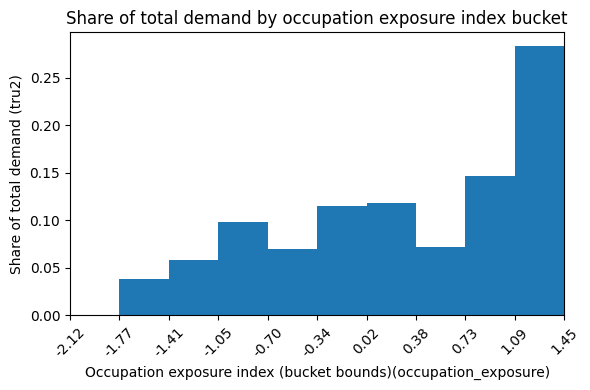

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_share_total_demand_by_exposure_bucket_tru2.png


In [ ]:
# Share of total demand by exposure bucket (histogram on bucket bounds)

bucket_total_tru2 = bucket_demand["demand_tru2"].sum()

# Ensure all buckets present (fill missing with 0)
all_buckets = pd.DataFrame({"occ_exp_bucket": range(len(bucket_edges)-1)})
bucket_full = all_buckets.merge(bucket_demand, on="occ_exp_bucket", how="left").fillna({"demand_tru2": 0})
bucket_full["share_of_tru2"] = bucket_full["demand_tru2"] / bucket_total_tru2 if bucket_total_tru2 else 0

left_edges = bucket_edges[:-1]
widths = np.diff(bucket_edges)

plt.figure(figsize=(6,4))
plt.bar(left_edges, bucket_full["share_of_tru2"], width=widths, align='edge')
plt.xlabel(f"Occupation exposure index (bucket bounds)({exposure_col})")
plt.ylabel("Share of total demand (tru2)")
plt.title("Share of total demand by occupation exposure index bucket")
plt.xlim(bucket_edges[0], bucket_edges[-1])
plt.xticks(bucket_edges, [f"{e:.2f}" for e in bucket_edges], rotation=45)
plt.tight_layout()
fig_path4b = OUT_VIS / "fig_share_total_demand_by_exposure_bucket_tru2.png"
plt.savefig(fig_path4b, dpi=150)
plt.show()
print("Saved", fig_path4b)


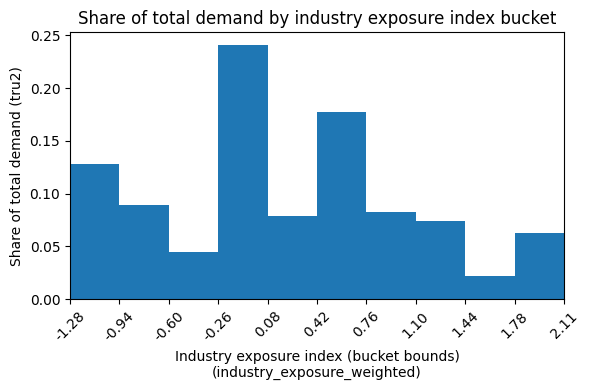

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/visuals/fig_share_total_demand_by_industry_exposure_bucket_tru2.png


In [ ]:
# Industry exposure: share of total demand by exposure bucket (histogram on bucket bounds)

ind_col = ind_exp_col
ind_nonmiss = _df[_df[ind_col].notna()].copy()
if ind_nonmiss.empty:
    print("No non-missing industry exposure values found for histogram.")
else:
    num_buckets_ind = 10
    ind_min = ind_nonmiss[ind_col].min()
    ind_max = ind_nonmiss[ind_col].max()
    ind_edges = np.linspace(ind_min, ind_max, num_buckets_ind + 1)

    ind_nonmiss["ind_exp_bucket"] = pd.cut(
        ind_nonmiss[ind_col],
        bins=ind_edges,
        labels=False,
        include_lowest=True
    )

    ind_bucket_demand = (
        ind_nonmiss.groupby("ind_exp_bucket")
        .agg(demand_tru2=("srvy_wght_tru2", "sum"))
        .reset_index()
    )

    ind_total_tru2 = ind_bucket_demand["demand_tru2"].sum()
    all_buckets_ind = pd.DataFrame({"ind_exp_bucket": range(len(ind_edges)-1)})
    ind_bucket_full = all_buckets_ind.merge(ind_bucket_demand, on="ind_exp_bucket", how="left").fillna({"demand_tru2": 0})
    ind_bucket_full["share_of_tru2"] = ind_bucket_full["demand_tru2"] / ind_total_tru2 if ind_total_tru2 else 0

    ind_left_edges = ind_edges[:-1]
    ind_widths = np.diff(ind_edges)

    plt.figure(figsize=(6,4))
    plt.bar(ind_left_edges, ind_bucket_full["share_of_tru2"], width=ind_widths, align='edge')
    plt.xlabel(f"Industry exposure index (bucket bounds)\n({ind_col})")
    plt.ylabel("Share of total demand (tru2)")
    plt.title("Share of total demand by industry exposure index bucket")
    plt.xlim(ind_edges[0], ind_edges[-1])
    plt.xticks(ind_edges, [f"{e:.2f}" for e in ind_edges], rotation=45)
    plt.tight_layout()
    fig_path_ind = OUT_VIS / "fig_share_total_demand_by_industry_exposure_bucket_tru2.png"
    plt.savefig(fig_path_ind, dpi=150)
    plt.show()
    print("Saved", fig_path_ind)
